In [1]:
## Built-in modules
import os

## Third party modules
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import OrderedDict
%matplotlib inline

## Local modules
# pip install biogeme
import biogeme.database as db
import biogeme.biogeme as bio
from biogeme import models
import biogeme.messaging as msg
import biogeme.tools as tools
import biogeme.results as res
from biogeme.expressions import Beta, DefineVariable, bioDraws, log, MonteCarlo

In [60]:
#import biogeme.results as res

In [2]:
# pd.__version__

## Read and process the CFS 2012 data

In [176]:
df_raw = pd.read_csv('cfs_2012_pumf_csv.txt')

## Only keep the TX Austin data + "Rest of TX"
df_tx = df_raw[(df_raw['ORIG_CFS_AREA'] == '48-12420') | (df_raw['ORIG_CFS_AREA'] == '48-41700') | 
               (df_raw['ORIG_CFS_AREA'] == '48-99999') | (df_raw['DEST_CFS_AREA'] == '48-12420') |  
               (df_raw['DEST_CFS_AREA'] == '48-41700') | (df_raw['DEST_CFS_AREA'] == '48-99999') ]

In [177]:
df_tx.head()

,SHIPMT_ID,ORIG_STATE,ORIG_MA,ORIG_CFS_AREA,DEST_STATE,DEST_MA,DEST_CFS_AREA,NAICS,QUARTER,SCTG,MODE,SHIPMT_VALUE,SHIPMT_WGHT,SHIPMT_DIST_GC,SHIPMT_DIST_ROUTED,TEMP_CNTL_YN,EXPORT_YN,EXPORT_CNTRY,HAZMAT,WGT_FACTOR
24,25,48,99999,48-99999,48,99999,48-99999,311,1,05,4,26498,33269,156,219,Y,N,N,N,114.3
43,44,48,41700,48-41700,48,41700,48-41700,4232,2,43,5,112,116,3,3,N,N,N,N,149.3
113,114,48,41700,48-41700,48,41700,48-41700,4244,2,05,5,94,28,6,8,Y,N,N,N,1667.7
145,146,48,99999,48-99999,48,99999,48-99999,4238,4,40,4,360,36,27,37,N,N,N,N,5080.7
169,170,51,99999,51-99999,48,99999,48-99999,326,4,24,4,22112,28239,1042,1290,N,N,N,N,106.6


In [178]:
df_tx.shape

(175395, 20)

In [179]:
df_tx['MODE'].value_counts()

4     72799
14    47848
5     47575
6      3120
11     2386
15     1077
2       241
12      154
13      112
20       25
8        25
0        21
3         6
16        3
7         3
Name: MODE, dtype: int64

### Generate mode choice variables

In [180]:
# df_ca['mode_agg'] = (df_ca.MODE).replace({3:'Truck', 4:'Truck', 5:'Truck', 6:'Rail/IMX', 15:'Rail/IMX', 11:'Air/Parcel', 14:'Air/Parcel'})

df_tx['mode_agg3'] = df_tx['MODE']
df_tx['mode_agg5'] = df_tx['MODE']

cleanup_decode = {"mode_agg5":   {4:'For-hire Truck', 
                                  5:'Private Truck', 
                                  6:'Rail/IMX', 
                                  15:'Rail/IMX', 
                                  11:'Air', 
                                  14:'Parcel', 
                                  0:'Other',
                                  2:'Other',
                                  3:'Other',
                                  7:'Other',
                                  8:'Other',
                                  10:'Other',
                                  12:'Other',
                                  13:'Other',
                                  16:'Other',
                                  20:'Other',
                                  101:'Other'},
                  "mode_agg3":    {3:'Truck',
                                  4:'Truck', 
                                  5:'Truck', 
                                  6:'Rail/IMX', 
                                  15:'Rail/IMX', 
                                  11:'Air/Parcel', 
                                  14:'Air/Parcel', 
                                  0:'Other',
                                  2:'Other',
                                  7:'Other',
                                  8:'Other',
                                  10:'Other',
                                  12:'Other',
                                  13:'Other',
                                  16:'Other',
                                  20:'Other',
                                  101:'Other'}}

df_tx = df_tx.replace(cleanup_decode)

C:\Users\hcyang\anaconda3\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [181]:
df_tx[['MODE','mode_agg3','mode_agg5']].head(20)

,MODE,mode_agg3,mode_agg5
24,4,Truck,For-hire Truck
43,5,Truck,Private Truck
113,5,Truck,Private Truck
145,4,Truck,For-hire Truck
169,4,Truck,For-hire Truck
183,14,Air/Parcel,Parcel
249,4,Truck,For-hire Truck
281,4,Truck,For-hire Truck
300,14,Air/Parcel,Parcel
369,5,Truck,Private Truck


In [182]:
df_tx['mode_agg5'].value_counts()

For-hire Truck    72799
Parcel            47848
Private Truck     47575
Rail/IMX           4197
Air                2386
Other               590
Name: mode_agg5, dtype: int64

In [183]:
## Remove shipment with mode other than the 5 modes

df_tx = df_tx[df_tx['mode_agg5'] != 'Other'] 

In [184]:
df_tx['mode_agg5'].value_counts()

For-hire Truck    72799
Parcel            47848
Private Truck     47575
Rail/IMX           4197
Air                2386
Name: mode_agg5, dtype: int64

### Generate commodity type variables

In [185]:
df_tx['SCTG'] = df_tx['SCTG'].astype(int)

In [186]:
df_tx['bulk'] = np.where((df_tx['SCTG'] == 2) | (df_tx['SCTG'] == 10) | (df_tx['SCTG'] == 11) | 
                         (df_tx['SCTG'] == 12) | (df_tx['SCTG'] == 13) | (df_tx['SCTG'] == 14) | 
                         (df_tx['SCTG'] == 15) | (df_tx['SCTG'] == 25) | (df_tx['SCTG'] == 26)| (df_tx['SCTG'] == 32), 1, 0)
df_tx['fuel_fert'] = np.where((df_tx['SCTG'] == 16) | (df_tx['SCTG'] == 17) | (df_tx['SCTG'] == 18) | 
                              (df_tx['SCTG'] == 19) | (df_tx['SCTG'] == 20) | (df_tx['SCTG'] == 22) | (df_tx['SCTG'] == 23), 1, 0)
df_tx['interm_food'] = np.where((df_tx['SCTG'] == 1) | (df_tx['SCTG'] == 3) | (df_tx['SCTG'] == 4) | 
                         (df_tx['SCTG'] == 5) | (df_tx['SCTG'] == 6) | (df_tx['SCTG'] == 7) | (df_tx['SCTG'] == 8), 1, 0)
df_tx['mfr_goods'] = np.where((df_tx['SCTG'] == 9) | (df_tx['SCTG'] == 21) | (df_tx['SCTG'] == 24) | 
                              (df_tx['SCTG'] == 27) | (df_tx['SCTG'] == 28) | (df_tx['SCTG'] == 29) | 
                              (df_tx['SCTG'] == 30) | (df_tx['SCTG'] == 31) | (df_tx['SCTG'] == 33) | 
                              (df_tx['SCTG'] == 34) | (df_tx['SCTG'] == 35) | (df_tx['SCTG'] == 36) |
                              (df_tx['SCTG'] == 37) | (df_tx['SCTG'] == 38) | (df_tx['SCTG'] == 39) | (df_tx['SCTG'] == 40), 1, 0)
df_tx['other'] = np.where((df_tx['SCTG'] == 41) | (df_tx['SCTG'] == 43) | (df_tx['SCTG'] == 99), 1, 0)

## pd.get_dummies() - https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html
## long_swiss_metro["single_luggage_piece"] = (long_swiss_metro["LUGGAGE"] == 1).astype(int)
## df_long['hot_climate'] = (df_long['climate_zone'].isin(['Hot-Dry', 'Hot-Humid'])).astype(int)

In [187]:
df_tx[['bulk', 'fuel_fert', 'interm_food', 'mfr_goods','other']]

,bulk,fuel_fert,interm_food,mfr_goods,other
24,0,0,1,0,0
43,0,0,0,0,1
113,0,0,1,0,0
145,0,0,0,1,0
169,0,0,0,1,0
...,...,...,...,...,...
4547531,1,0,0,0,0
4547584,0,0,0,1,0
4547612,0,0,0,1,0
4547615,0,0,0,1,0


In [188]:
commodity_dict = {2:'bulk', 10:'bulk', 11:'bulk', 12:'bulk', 13:'bulk', 14:'bulk', 15:'bulk', 25:'bulk', 26:'bulk', 32:'bulk',
                  16:'fuel_fert', 17:'fuel_fert', 18:'fuel_fert', 19:'fuel_fert', 20:'fuel_fert', 22:'fuel_fert', 23:'fuel_fert',
                  1:'interm_food', 3:'interm_food', 4:'interm_food', 5:'interm_food', 6:'interm_food', 7:'interm_food', 8:'interm_food',
                  9:'mfr_goods', 21:'mfr_goods', 24:'mfr_goods', 27:'mfr_goods', 28:'mfr_goods', 29:'mfr_goods', 30:'mfr_goods', 
                  31:'mfr_goods', 33:'mfr_goods', 34:'mfr_goods', 35:'mfr_goods', 36:'mfr_goods', 37:'mfr_goods', 38:'mfr_goods', 
                  39:'mfr_goods', 40:'mfr_goods',
                  41:'other', 43:'other', 99:'other'}

df_tx['commodity'] = df_tx['SCTG'].map(commodity_dict)

#df_tx['commodity'] = (df_tx.SCTG).replace(commodity_dict)

In [189]:
df_tx['commodity'].value_counts(dropna=False)

mfr_goods      107872
bulk            19678
interm_food     17911
fuel_fert       16542
other           12802
Name: commodity, dtype: int64

In [190]:
df_tx.groupby(['mode_agg5','commodity'])['WGT_FACTOR'].agg('count')

mode_agg5       commodity  
Air             bulk              68
                fuel_fert         77
                interm_food       28
                mfr_goods       2193
                other             20
For-hire Truck  bulk           10416
                fuel_fert       7142
                interm_food     8020
                mfr_goods      43733
                other           3488
Parcel          bulk             937
                fuel_fert       1885
                interm_food      902
                mfr_goods      41779
                other           2345
Private Truck   bulk            7030
                fuel_fert       6802
                interm_food     8481
                mfr_goods      18578
                other           6684
Rail/IMX        bulk            1227
                fuel_fert        636
                interm_food      480
                mfr_goods       1589
                other            265
Name: WGT_FACTOR, dtype: int64

### Generate NAICS industry type variables

In [191]:
df_tx['naics2'] = df_tx['NAICS'].astype(str).str[:2].astype(int)

In [192]:
df_tx['naics_name'] = (df_tx.naics2).replace({21:'Mining', 
                                              31:'Manufacturing',
                                              32:'Manufacturing',
                                              33:'Manufacturing',
                                              42:'Wholesale',
                                              45:'Retail',
                                              49:'Trans_Warehouse',
                                              51:'Information',
                                              55:'Mgt_companies'})

df_tx['naics_name'].value_counts() 

Manufacturing      89647
Wholesale          65568
Retail              5973
Mining              5875
Trans_Warehouse     4441
Information         2080
Mgt_companies       1221
Name: naics_name, dtype: int64

In [193]:
df_tx.groupby(['mode_agg5','naics_name'])['WGT_FACTOR'].agg('count')

mode_agg5       naics_name     
Air             Information           29
                Manufacturing       1523
                Mgt_companies         44
                Retail               106
                Trans_Warehouse       15
                Wholesale            669
For-hire Truck  Information          233
                Manufacturing      48047
                Mgt_companies        485
                Mining              2715
                Retail               297
                Trans_Warehouse     2231
                Wholesale          18791
Parcel          Information         1087
                Manufacturing      23904
                Mgt_companies        408
                Mining                 1
                Retail              3911
                Trans_Warehouse      694
                Wholesale          17843
Private Truck   Information          728
                Manufacturing      13568
                Mgt_companies        266
                Mining   

In [194]:
df_tx.groupby(['mode_agg5','naics_name'])['WGT_FACTOR'].agg('count')

mode_agg5       naics_name     
Air             Information           29
                Manufacturing       1523
                Mgt_companies         44
                Retail               106
                Trans_Warehouse       15
                Wholesale            669
For-hire Truck  Information          233
                Manufacturing      48047
                Mgt_companies        485
                Mining              2715
                Retail               297
                Trans_Warehouse     2231
                Wholesale          18791
Parcel          Information         1087
                Manufacturing      23904
                Mgt_companies        408
                Mining                 1
                Retail              3911
                Trans_Warehouse      694
                Wholesale          17843
Private Truck   Information          728
                Manufacturing      13568
                Mgt_companies        266
                Mining   

In [195]:
df_tx["wholesale"] = (df_tx['naics_name'] == "Wholesale").astype(int)
df_tx["mfring"] = (df_tx['naics_name'] == "Manufacturing").astype(int)
df_tx["mining"] = (df_tx['naics_name'] == "Mining").astype(int)
df_tx["retail"] = (df_tx['naics_name'] == "Retail").astype(int)
df_tx["info"] = (df_tx['naics_name'] == "Information").astype(int)
df_tx["management"] = (df_tx['naics_name'] == "Mgt_companies").astype(int)
df_tx["transwarehouse"] = (df_tx['naics_name'] == "Trans_Warehouse").astype(int)

### Generate shipment weight bins

In [196]:
df_tx['wght_bin1'] = np.where(df_tx['SHIPMT_WGHT'] <= 150, 1,
                     np.where((df_tx['SHIPMT_WGHT'] > 150) & (df_tx['SHIPMT_WGHT'] <= 1500), 2,
                     np.where((df_tx['SHIPMT_WGHT'] > 1500) & (df_tx['SHIPMT_WGHT'] <= 30000), 3,
                     np.where((df_tx['SHIPMT_WGHT'] > 30000) & (df_tx['SHIPMT_WGHT'] <= 45000), 4, 5))))

df_tx['wght_bin2'] = np.where(df_tx['SHIPMT_WGHT'] <= 150, 1,
                     np.where((df_tx['SHIPMT_WGHT'] > 150) & (df_tx['SHIPMT_WGHT'] <= 1000), 2,
                     np.where((df_tx['SHIPMT_WGHT'] > 1000) & (df_tx['SHIPMT_WGHT'] <= 5000), 3,
                     np.where((df_tx['SHIPMT_WGHT'] > 5000) & (df_tx['SHIPMT_WGHT'] <= 35000), 4, 5))))

### Generate additional variables

In [197]:
df_tx['geo'] = np.where(((df_tx['ORIG_CFS_AREA'] == '48-12420') | (df_tx['ORIG_CFS_AREA'] == '48-41700')) & 
               ((df_tx['DEST_CFS_AREA'] == '48-12420') | (df_tx['DEST_CFS_AREA'] == '48-41700')), 'Within Austin', 'External')

df_tx['SHIPMT_WGHT_TON'] = df_tx['SHIPMT_WGHT']/2000

df_tx['value_density'] = df_tx['SHIPMT_VALUE']/df_tx['SHIPMT_WGHT']

df_tx['SHIPMT_DIST'] = df_tx['SHIPMT_DIST_ROUTED']
df_tx['SHIPMT_DIST'] = np.where((df_tx['mode_agg5'] == 'Air') | (df_tx['mode_agg5'] == 'Parcel'), 
                                df_tx['SHIPMT_DIST_GC'],df_tx['SHIPMT_DIST']) # Use GC distance for Air and Parcel and Routed distance for the rest of modes.

### Additional data removal rules

In [153]:
df_tx.groupby(['mode_agg5'])['value_density'].describe()

,count,mean,std,min,25%,50%,75%,max
mode_agg5,,,,,,,,
Air,2386.0,428.934410,1916.661153,0.032258,23.261574,85.880282,272.000000,46452.0
For-hire Truck,72799.0,23.402676,415.408867,0.000187,0.603853,1.965169,6.249811,88343.0
Parcel,47848.0,208.269397,7002.525221,0.016129,8.875000,23.666667,72.000000,1510121.0
Private Truck,47575.0,9.682768,78.964557,0.000496,0.381044,1.178571,4.065270,6721.0
Rail/IMX,4197.0,0.996415,10.639044,0.001248,0.079606,0.259485,0.658478,468.5


In [46]:
df_tx.groupby(['commodity'])['value_density'].describe()

,count,mean,std,min,25%,50%,75%,max
commodity,,,,,,,,
bulk,9310.0,1.326837,86.181354,0.000500,0.005397,0.054170,0.152675,8.309000e+03
fuel_fert,3448.0,0.468676,0.755504,0.007495,0.300010,0.447097,0.500000,2.702110e+01
interm_food,52403.0,12.000887,133.552370,0.000496,0.329994,0.996379,2.753295,8.178400e+03
mfr_goods,78311.0,100.197170,684.762650,0.003460,3.100713,10.744681,39.000000,6.822700e+04
other,31333.0,148.975545,8625.656880,0.000187,1.251417,4.025394,17.000000,1.510121e+06


In [198]:
## based on Stinson et al. (2017)

df_tx.drop(df_tx[(df_tx['mode_agg5'] == 'Air') & (df_tx['SHIPMT_WGHT'] > 15000)].index, inplace = True)
df_tx.drop(df_tx[(df_tx['mode_agg5'] == 'Air') & (df_tx['SHIPMT_WGHT'] > 150) & (df_tx['value_density'] < 1)].index, inplace = True)
df_tx.drop(df_tx[(df_tx['mode_agg5'] == 'Parcel') & (df_tx['SHIPMT_WGHT'] > 150) & (df_tx['value_density'] < 1)].index, inplace = True)
df_tx.drop(df_tx[(df_tx['MODE'] == 6) & (df_tx['SHIPMT_WGHT'] < 1500)].index, inplace = True)
df_tx.drop(df_tx[(df_tx['MODE'] == 6) & (df_tx['value_density'] >= 4)].index, inplace = True)


In [155]:
df_tx.shape

(174715, 43)

In [26]:
df_tx.groupby(['mode_agg5'])['WGT_FACTOR'].agg('sum')

mode_agg5
Air                 5544113.7
For-hire Truck     93041401.5
Parcel            232764459.5
Private Truck     133631346.9
Rail/IMX             823770.3
Name: WGT_FACTOR, dtype: float64

In [131]:
df_tx.groupby(['mode_agg5','wght_bin1'])['WGT_FACTOR'].agg('count')

mode_agg5       wght_bin1
Air             1             2032
                2              292
                3               47
For-hire Truck  1            12628
                2            17950
                3            20290
                4            11759
                5            10172
Parcel          1            47714
                2              130
Private Truck   1            14775
                2            11679
                3            11956
                4             4747
                5             4418
Rail/IMX        1               18
                2               28
                3              266
                4              232
                5             3582
Name: WGT_FACTOR, dtype: int64

## Biogeme Estimation Setup 

### Create the 'choice' and 'availability' variables

In [226]:
## alt_1 = Air, alt_2 = For-hire Truck, alt_3 = Parcel, alt_4 = Private Truck, alt_5 = Rail/IMX 

choice_dictionary ={'Air' : 1, 'For-hire Truck' : 2, 'Parcel' : 3, 'Private Truck': 4, 'Rail/IMX':5}
df_tx['choice'] = df_tx['mode_agg5'].map(choice_dictionary).astype(int)

## Following the same conditions described in Keya (2016)
#df_tx['AV_1'] = np.where(((df_tx['SHIPMT_WGHT'] <= 4656) | (df_tx['mode_agg5'] == 'Air')), 1, 0)
#df_tx['AV_2'] = 1
#df_tx['AV_3'] = np.where(((df_tx['SHIPMT_WGHT'] <= 150) | (df_tx['mode_agg5'] == 'Parcel')), 1, 0) # change from 127 lb to 150 lb
#df_tx['AV_4'] = np.where(((df_tx['SHIPMT_DIST_ROUTED'] <= 425) | (df_tx['mode_agg5'] == 'Private Truck')), 1, 0) 
#df_tx['AV_5'] = 1 


## NEW mode constraints on 03/31/2022 --> change the threshold from using the national sample to the Austin sample
df_tx['AV_1a'] = np.where(((df_tx['SHIPMT_WGHT_TON'] <= 1.862) | (df_tx['mode_agg5'] == 'Air')), 1, 0) # the treshold is the Austin 99th (unweighted)
df_tx['AV_2a'] = 1
df_tx['AV_3a'] = 1 # makes Parcel always available
df_tx['AV_4a'] = np.where(((df_tx['SHIPMT_DIST_ROUTED'] <= 452) | (df_tx['mode_agg5'] == 'Private Truck')), 1, 0) # the treshold is the Austin 99th (unweighted)
df_tx['AV_5a'] = 1

## NEW mode constraints on 04/01/2022 --> add the parcel filter back
df_tx['AV_1b'] = np.where(((df_tx['SHIPMT_WGHT_TON'] <= 1.862) | (df_tx['mode_agg5'] == 'Air')), 1, 0) # the treshold is the Austin 99th (unweighted)
df_tx['AV_2b'] = 1
df_tx['AV_3b'] = np.where(((df_tx['SHIPMT_WGHT'] <= 150) | (df_tx['mode_agg5'] == 'Parcel')), 1, 0)
df_tx['AV_4b'] = np.where(((df_tx['SHIPMT_DIST_ROUTED'] <= 452) | (df_tx['mode_agg5'] == 'Private Truck')), 1, 0) # the treshold is the Austin 99th (unweighted)
df_tx['AV_5b'] = 1

## NEW mode constraints on 04/01/2022 --> add the parcel filter back, but make air and private truck threshold at the max national sample
df_tx['AV_1c'] = np.where(((df_tx['SHIPMT_WGHT_TON'] <= 550) | (df_tx['mode_agg5'] == 'Air')), 1, 0) # the treshold is the national max (unweighted)
df_tx['AV_2c'] = 1
df_tx['AV_3c'] = np.where(((df_tx['SHIPMT_WGHT'] <= 150) | (df_tx['mode_agg5'] == 'Parcel')), 1, 0)
df_tx['AV_4c'] = np.where(((df_tx['SHIPMT_DIST_ROUTED'] <= 500) | (df_tx['mode_agg5'] == 'Private Truck')), 1, 0) # the treshold is the national max (unweighted)
df_tx['AV_5c'] = 1


### Create TravelTime and ShipCost variables

In [202]:
## We assume that For-hire Truck and Private Truck have the same travel time and shipping costs.
## The calculations for Rail/IMX, For-hire Truck and Private Truck are based on Stinson et al. (2017)
## The calculations for Air and Parcel are based on Keya (2016), minor modification to Air (adding loading time for external shipments)

df_tx['random_a'] = np.random.rand(df_tx.shape[0])

df_tx['random_b'] = np.NaN
m = df_tx['AV_3b'] == 1
df_tx.loc[m, 'random_b'] = np.random.rand(m.sum()) ## We are assigning different shipping speeds for Parcels based on a distribution; hence we need to generate this 'random' variable first 

df_tx['alt_1_traveltime'] = np.where(df_tx['geo'] == 'Within Austin', 1 + df_tx['SHIPMT_DIST_GC']/549.5,
                            np.where(df_tx['geo'] == 'External', 12 + df_tx['SHIPMT_DIST_GC']/549.5,
                            np.nan)) # assume average speed of 549.5 mph
df_tx['alt_2_traveltime'] = np.where(df_tx['geo'] == 'Within Austin', 4 + df_tx['SHIPMT_DIST_ROUTED']/20,
                            np.where((df_tx['geo'] == 'External') & (df_tx['SHIPMT_DIST_ROUTED'] <= 650), 16 + df_tx['SHIPMT_DIST_ROUTED']/65,
                            np.where((df_tx['geo'] == 'External') & (df_tx['SHIPMT_DIST_ROUTED'] > 650) & (df_tx['SHIPMT_DIST_ROUTED'] <= 1299), 16 + df_tx['SHIPMT_DIST_ROUTED']/38,
                            np.where((df_tx['geo'] == 'External') & (df_tx['SHIPMT_DIST_ROUTED'] > 1299), 16 + df_tx['SHIPMT_DIST_ROUTED']/32, np.nan)))) 
df_tx['alt_3_traveltime_a'] = np.where(df_tx['random_a'] <= 0.09, 3*24,
                            np.where((df_tx['random_a'] > 0.09) & (df_tx['random_a'] <= 0.27), 24,
                            np.where(df_tx['random_a'] > 0.27, 5*24, np.nan)))
df_tx['alt_3_traveltime_b'] = np.where(df_tx['random_b'] <= 0.09, 3*24,
                            np.where((df_tx['random_b'] > 0.09) & (df_tx['random_b'] <= 0.27), 24,
                            np.where(df_tx['random_b'] > 0.27, 5*24, np.nan)))
df_tx['alt_4_traveltime'] =np.where(df_tx['geo'] == 'Within Austin', 4 + df_tx['SHIPMT_DIST_ROUTED']/20,
                           np.where((df_tx['geo'] == 'External') & (df_tx['SHIPMT_DIST_ROUTED'] <= 650), 16 + df_tx['SHIPMT_DIST_ROUTED']/65,
                           np.where((df_tx['geo'] == 'External') & (df_tx['SHIPMT_DIST_ROUTED'] > 650) & (df_tx['SHIPMT_DIST_ROUTED'] <= 1299), 16 + df_tx['SHIPMT_DIST_ROUTED']/38,
                           np.where((df_tx['geo'] == 'External') & (df_tx['SHIPMT_DIST_ROUTED'] > 1299), 16 + df_tx['SHIPMT_DIST_ROUTED']/32, np.nan)))) 
df_tx['alt_5_traveltime'] = 12 + df_tx['SHIPMT_DIST_ROUTED']/22 + 12*2 # Assume 2 trackage changes

df_tx['alt_1_shipcost'] = np.where(df_tx['SHIPMT_WGHT'] <= 100, 55, 55+(df_tx['SHIPMT_WGHT']-100))
df_tx['alt_2_shipcost'] = np.where(df_tx['SHIPMT_WGHT'] < 150, 2.83*df_tx['SHIPMT_WGHT_TON']*df_tx['SHIPMT_DIST_GC'],
                          np.where((df_tx['SHIPMT_WGHT'] >= 150) & (df_tx['SHIPMT_WGHT'] < 1500), 0.50*df_tx['SHIPMT_WGHT_TON']*df_tx['SHIPMT_DIST_GC'],
                          np.where(df_tx['SHIPMT_WGHT'] >= 1500, 0.18*df_tx['SHIPMT_WGHT_TON']*df_tx['SHIPMT_DIST_GC'], np.NaN)))
df_tx['alt_3_shipcost_a'] = np.where((df_tx['random_a'] > 0.27) & (df_tx['SHIPMT_DIST_ROUTED'] <= 150), np.exp(2.056+0.016*df_tx['SHIPMT_WGHT']),
                          np.where((df_tx['random_a'] > 0.27) & (df_tx['SHIPMT_DIST_ROUTED'] > 150) & (df_tx['SHIPMT_DIST_ROUTED'] <= 300), np.exp(2.251+0.015*df_tx['SHIPMT_WGHT']), 
                          np.where((df_tx['random_a'] > 0.27) & (df_tx['SHIPMT_DIST_ROUTED'] > 300) & (df_tx['SHIPMT_DIST_ROUTED'] <= 600), np.exp(2.362+0.015*df_tx['SHIPMT_WGHT']),
                          np.where((df_tx['random_a'] > 0.27) & (df_tx['SHIPMT_DIST_ROUTED'] > 600) & (df_tx['SHIPMT_DIST_ROUTED'] <= 1000), np.exp(2.555+0.014*df_tx['SHIPMT_WGHT']), 
                          np.where((df_tx['random_a'] > 0.27) & (df_tx['SHIPMT_DIST_ROUTED'] > 1000) & (df_tx['SHIPMT_DIST_ROUTED'] <= 1400), np.exp(2.739+0.013*df_tx['SHIPMT_WGHT']), 
                          np.where((df_tx['random_a'] > 0.27) & (df_tx['SHIPMT_DIST_ROUTED'] > 1400) & (df_tx['SHIPMT_DIST_ROUTED'] <= 1800), np.exp(2.905+0.013*df_tx['SHIPMT_WGHT']), 
                          np.where((df_tx['random_a'] > 0.27) & (df_tx['SHIPMT_DIST_ROUTED'] > 1800), np.exp(3.023+0.013*df_tx['SHIPMT_WGHT']),
                          np.where((df_tx['random_a'] > 0.09) & (df_tx['random_a'] <= 0.27) & (df_tx['SHIPMT_DIST_ROUTED'] <= 150), np.exp(3.666+0.015*df_tx['SHIPMT_WGHT']),
                          np.where((df_tx['random_a'] > 0.09) & (df_tx['random_a'] <= 0.27) & (df_tx['SHIPMT_DIST_ROUTED'] > 150) & (df_tx['SHIPMT_DIST_ROUTED'] <= 300), np.exp(3.993+0.016*df_tx['SHIPMT_WGHT']), 
                          np.where((df_tx['random_a'] > 0.09) & (df_tx['random_a'] <= 0.27) & (df_tx['SHIPMT_DIST_ROUTED'] > 300) & (df_tx['SHIPMT_DIST_ROUTED'] <= 600), np.exp(4.631+0.01*df_tx['SHIPMT_WGHT']),
                          np.where((df_tx['random_a'] > 0.09) & (df_tx['random_a'] <= 0.27) & (df_tx['SHIPMT_DIST_ROUTED'] > 600) & (df_tx['SHIPMT_DIST_ROUTED'] <= 1000), np.exp(4.700+0.01*df_tx['SHIPMT_WGHT']), 
                          np.where((df_tx['random_a'] > 0.09) & (df_tx['random_a'] <= 0.27) & (df_tx['SHIPMT_DIST_ROUTED'] > 1000) & (df_tx['SHIPMT_DIST_ROUTED'] <= 1400), np.exp(4.767+0.015*df_tx['SHIPMT_WGHT']), 
                          np.where((df_tx['random_a'] > 0.09) & (df_tx['random_a'] <= 0.27) & (df_tx['SHIPMT_DIST_ROUTED'] > 1400) & (df_tx['SHIPMT_DIST_ROUTED'] <= 1800), np.exp(4.798+0.015*df_tx['SHIPMT_WGHT']), 
                          np.where((df_tx['random_a'] > 0.09) & (df_tx['random_a'] <= 0.27) & (df_tx['SHIPMT_DIST_ROUTED'] > 1800), np.exp(4.855+0.015*df_tx['SHIPMT_WGHT']),
                          np.where((df_tx['random_a'] <= 0.09) & (df_tx['SHIPMT_DIST_ROUTED'] <= 150), np.exp(3.208+0.014*df_tx['SHIPMT_WGHT']),
                          np.where((df_tx['random_a'] <= 0.09) & (df_tx['SHIPMT_DIST_ROUTED'] > 150) & (df_tx['SHIPMT_DIST_ROUTED'] <= 300), np.exp(3.399+0.015*df_tx['SHIPMT_WGHT']), 
                          np.where((df_tx['random_a'] <= 0.09) & (df_tx['SHIPMT_DIST_ROUTED'] > 300) & (df_tx['SHIPMT_DIST_ROUTED'] <= 600), np.exp(3.560+0.015*df_tx['SHIPMT_WGHT']),
                          np.where((df_tx['random_a'] <= 0.09) & (df_tx['SHIPMT_DIST_ROUTED'] > 600) & (df_tx['SHIPMT_DIST_ROUTED'] <= 1000), np.exp(3.624+0.016*df_tx['SHIPMT_WGHT']), 
                          np.where((df_tx['random_a'] <= 0.09) & (df_tx['SHIPMT_DIST_ROUTED'] > 1000) & (df_tx['SHIPMT_DIST_ROUTED'] <= 1400), np.exp(3.908+0.016*df_tx['SHIPMT_WGHT']), 
                          np.where((df_tx['random_a'] <= 0.09) & (df_tx['SHIPMT_DIST_ROUTED'] > 1400) & (df_tx['SHIPMT_DIST_ROUTED'] <= 1800), np.exp(4.010+0.016*df_tx['SHIPMT_WGHT']), 
                          np.where((df_tx['random_a'] <= 0.09) & (df_tx['SHIPMT_DIST_ROUTED'] > 1800), np.exp(4.158+0.016*df_tx['SHIPMT_WGHT']), np.NaN)))))))))))))))))))))
df_tx['alt_3_shipcost_b'] = np.where((df_tx['random_b'] > 0.27) & (df_tx['SHIPMT_DIST_ROUTED'] <= 150), np.exp(2.056+0.016*df_tx['SHIPMT_WGHT']),
                          np.where((df_tx['random_b'] > 0.27) & (df_tx['SHIPMT_DIST_ROUTED'] > 150) & (df_tx['SHIPMT_DIST_ROUTED'] <= 300), np.exp(2.251+0.015*df_tx['SHIPMT_WGHT']), 
                          np.where((df_tx['random_b'] > 0.27) & (df_tx['SHIPMT_DIST_ROUTED'] > 300) & (df_tx['SHIPMT_DIST_ROUTED'] <= 600), np.exp(2.362+0.015*df_tx['SHIPMT_WGHT']),
                          np.where((df_tx['random_b'] > 0.27) & (df_tx['SHIPMT_DIST_ROUTED'] > 600) & (df_tx['SHIPMT_DIST_ROUTED'] <= 1000), np.exp(2.555+0.014*df_tx['SHIPMT_WGHT']), 
                          np.where((df_tx['random_b'] > 0.27) & (df_tx['SHIPMT_DIST_ROUTED'] > 1000) & (df_tx['SHIPMT_DIST_ROUTED'] <= 1400), np.exp(2.739+0.013*df_tx['SHIPMT_WGHT']), 
                          np.where((df_tx['random_b'] > 0.27) & (df_tx['SHIPMT_DIST_ROUTED'] > 1400) & (df_tx['SHIPMT_DIST_ROUTED'] <= 1800), np.exp(2.905+0.013*df_tx['SHIPMT_WGHT']), 
                          np.where((df_tx['random_b'] > 0.27) & (df_tx['SHIPMT_DIST_ROUTED'] > 1800), np.exp(3.023+0.013*df_tx['SHIPMT_WGHT']),
                          np.where((df_tx['random_b'] > 0.09) & (df_tx['random_b'] <= 0.27) & (df_tx['SHIPMT_DIST_ROUTED'] <= 150), np.exp(3.666+0.015*df_tx['SHIPMT_WGHT']),
                          np.where((df_tx['random_b'] > 0.09) & (df_tx['random_b'] <= 0.27) & (df_tx['SHIPMT_DIST_ROUTED'] > 150) & (df_tx['SHIPMT_DIST_ROUTED'] <= 300), np.exp(3.993+0.016*df_tx['SHIPMT_WGHT']), 
                          np.where((df_tx['random_b'] > 0.09) & (df_tx['random_b'] <= 0.27) & (df_tx['SHIPMT_DIST_ROUTED'] > 300) & (df_tx['SHIPMT_DIST_ROUTED'] <= 600), np.exp(4.631+0.01*df_tx['SHIPMT_WGHT']),
                          np.where((df_tx['random_b'] > 0.09) & (df_tx['random_b'] <= 0.27) & (df_tx['SHIPMT_DIST_ROUTED'] > 600) & (df_tx['SHIPMT_DIST_ROUTED'] <= 1000), np.exp(4.700+0.01*df_tx['SHIPMT_WGHT']), 
                          np.where((df_tx['random_b'] > 0.09) & (df_tx['random_b'] <= 0.27) & (df_tx['SHIPMT_DIST_ROUTED'] > 1000) & (df_tx['SHIPMT_DIST_ROUTED'] <= 1400), np.exp(4.767+0.015*df_tx['SHIPMT_WGHT']), 
                          np.where((df_tx['random_b'] > 0.09) & (df_tx['random_b'] <= 0.27) & (df_tx['SHIPMT_DIST_ROUTED'] > 1400) & (df_tx['SHIPMT_DIST_ROUTED'] <= 1800), np.exp(4.798+0.015*df_tx['SHIPMT_WGHT']), 
                          np.where((df_tx['random_b'] > 0.09) & (df_tx['random_b'] <= 0.27) & (df_tx['SHIPMT_DIST_ROUTED'] > 1800), np.exp(4.855+0.015*df_tx['SHIPMT_WGHT']),
                          np.where((df_tx['random_b'] <= 0.09) & (df_tx['SHIPMT_DIST_ROUTED'] <= 150), np.exp(3.208+0.014*df_tx['SHIPMT_WGHT']),
                          np.where((df_tx['random_b'] <= 0.09) & (df_tx['SHIPMT_DIST_ROUTED'] > 150) & (df_tx['SHIPMT_DIST_ROUTED'] <= 300), np.exp(3.399+0.015*df_tx['SHIPMT_WGHT']), 
                          np.where((df_tx['random_b'] <= 0.09) & (df_tx['SHIPMT_DIST_ROUTED'] > 300) & (df_tx['SHIPMT_DIST_ROUTED'] <= 600), np.exp(3.560+0.015*df_tx['SHIPMT_WGHT']),
                          np.where((df_tx['random_b'] <= 0.09) & (df_tx['SHIPMT_DIST_ROUTED'] > 600) & (df_tx['SHIPMT_DIST_ROUTED'] <= 1000), np.exp(3.624+0.016*df_tx['SHIPMT_WGHT']), 
                          np.where((df_tx['random_b'] <= 0.09) & (df_tx['SHIPMT_DIST_ROUTED'] > 1000) & (df_tx['SHIPMT_DIST_ROUTED'] <= 1400), np.exp(3.908+0.016*df_tx['SHIPMT_WGHT']), 
                          np.where((df_tx['random_b'] <= 0.09) & (df_tx['SHIPMT_DIST_ROUTED'] > 1400) & (df_tx['SHIPMT_DIST_ROUTED'] <= 1800), np.exp(4.010+0.016*df_tx['SHIPMT_WGHT']), 
                          np.where((df_tx['random_b'] <= 0.09) & (df_tx['SHIPMT_DIST_ROUTED'] > 1800), np.exp(4.158+0.016*df_tx['SHIPMT_WGHT']), np.NaN)))))))))))))))))))))
df_tx['alt_4_shipcost'] = np.where(df_tx['SHIPMT_WGHT'] < 150, 2.83*df_tx['SHIPMT_WGHT_TON']*df_tx['SHIPMT_DIST_GC'],
                          np.where((df_tx['SHIPMT_WGHT'] >= 150) & (df_tx['SHIPMT_WGHT'] < 1500), 0.50*df_tx['SHIPMT_WGHT_TON']*df_tx['SHIPMT_DIST_GC'],
                          np.where(df_tx['SHIPMT_WGHT'] >= 1500, 0.18*df_tx['SHIPMT_WGHT_TON']*df_tx['SHIPMT_DIST_GC'], np.NaN)))
df_tx['alt_5_shipcost'] = 0.039*df_tx['SHIPMT_WGHT_TON']*df_tx['SHIPMT_DIST_ROUTED']



C:\Users\hcyang\anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


### Create Biogeme datasets

In [227]:
## Biogeme only take dataset that contains numbers
df_tx_short = df_tx[['SHIPMT_ID','SHIPMT_DIST','SHIPMT_DIST_GC','SHIPMT_DIST_ROUTED','SHIPMT_WGHT_TON','value_density',
                    'bulk','fuel_fert','interm_food','mfr_goods',
                    'other','wholesale','mfring','mining','retail',
                    'info','management','transwarehouse','alt_1_traveltime','alt_2_traveltime','alt_3_traveltime_a','alt_3_traveltime_b',
                     'alt_4_traveltime','alt_5_traveltime',
                     'alt_1_shipcost','alt_2_shipcost','alt_3_shipcost_a','alt_3_shipcost_b','alt_4_shipcost','alt_5_shipcost','choice',
                     'AV_1a','AV_2a','AV_3a','AV_4a','AV_5a','AV_1b','AV_2b','AV_3b','AV_4b','AV_5b','AV_1c','AV_2c','AV_3c','AV_4c','AV_5c',
                     'WGT_FACTOR','wght_bin1','wght_bin2']]

In [228]:
df_tx_short.columns[df_tx_short.isna().any()].tolist() # 'alt_3_traveltime' and 'alt_3_shipcost' contain NaN

df_tx_short = df_tx_short.fillna(0).copy() # Biogeme does not allow NaN in dataset

df_tx_short['random'] = np.random.rand(df_tx_short.shape[0]) ## random numbers from a uniform distribution over [0, 1).

df_tx_short_subset = df_tx_short[df_tx_short['random'] <= 0.50]
#df_ca_short_subset1 = df_ca_short[df_ca_short['random'] <= 0.10]
#df_ca_short_subset.shape

#### Detour: Correlation matrix between weight and shipping cost

In [93]:
import seaborn as sns

Text(0.5, 1.0, '...')

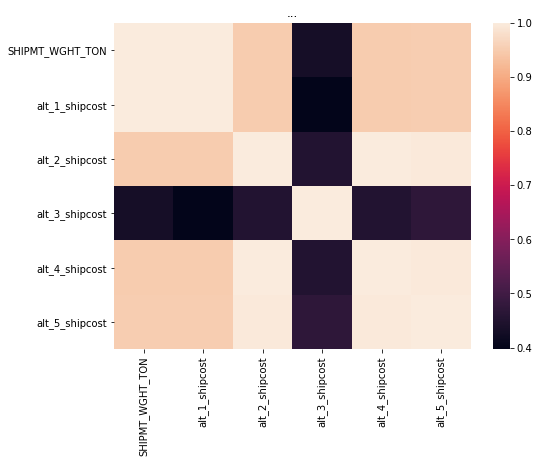

In [95]:
df_tx_corr = df_tx[['SHIPMT_WGHT_TON','alt_1_shipcost','alt_2_shipcost','alt_3_shipcost','alt_4_shipcost','alt_5_shipcost']]
plt.figure(figsize=(8,6))
wght_cost_corr = df_tx_corr.corr()
sns.heatmap(wght_cost_corr)
plt.title('...')

Text(0.5, 1.0, '...')

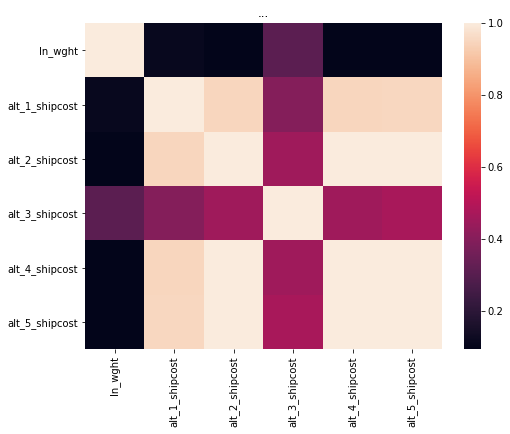

In [97]:
df_tx_corr['ln_wght'] = np.log(df_tx_corr['SHIPMT_WGHT_TON'])

df_tx_corr2 = df_tx_corr[['ln_wght','alt_1_shipcost','alt_2_shipcost','alt_3_shipcost','alt_4_shipcost','alt_5_shipcost']].copy()
plt.figure(figsize=(8,6))
wght_cost_corr2 = df_tx_corr2.corr()
sns.heatmap(wght_cost_corr2)
plt.title('...')

#### --------------------------------------------------------------------------------------------------------

In [229]:
database = db.Database('2012cfs_tx', df_tx_short)  
database_sub = db.Database('2012cfs_tx_sub', df_tx_short_subset)

## The following statement allows you to use the names of the variable as Python variable.
globals().update(database.variables)

In [230]:
database.fullData

,SHIPMT_ID,SHIPMT_DIST,SHIPMT_DIST_GC,SHIPMT_DIST_ROUTED,SHIPMT_WGHT_TON,value_density,bulk,fuel_fert,interm_food,mfr_goods,...,AV_5b,AV_1c,AV_2c,AV_3c,AV_4c,AV_5c,WGT_FACTOR,wght_bin1,wght_bin2,random
24,25,219,156,219,16.6345,0.796477,0,0,1,0,...,1,1,1,0,1,1,114.3,4,4,0.624116
43,44,3,3,3,0.0580,0.965517,0,0,0,0,...,1,1,1,1,1,1,149.3,1,1,0.604103
113,114,8,6,8,0.0140,3.357143,0,0,1,0,...,1,1,1,1,1,1,1667.7,1,1,0.454200
145,146,37,27,37,0.0180,10.000000,0,0,0,1,...,1,1,1,1,1,1,5080.7,1,1,0.821108
169,170,1290,1042,1290,14.1195,0.783031,0,0,0,1,...,1,1,1,0,0,1,106.6,3,4,0.410938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4547531,4547532,1307,1088,1307,0.3285,1.905632,1,0,0,0,...,1,1,1,0,0,1,90.7,2,2,0.601056
4547584,4547585,1483,1483,1727,0.0015,13.333333,0,0,0,1,...,1,1,1,1,0,1,14441.7,1,1,0.010794
4547612,4547613,115,115,136,0.0010,128.000000,0,0,0,1,...,1,1,1,1,1,1,4802.1,1,1,0.228568
4547615,4547616,1353,1193,1353,1.1375,23.575385,0,0,0,1,...,1,1,1,0,0,1,82.0,3,3,0.358030


## Model Specifications

### Case-specific vars: weight_ton + distance + commodities + val_density + all naics

In [33]:
# Parameters to be estimated
# (0, None, None, 0/1) --> (starting value, lower bound, upper bound, included/excluded in the estimation)
ASC_AIR = Beta('ASC_AIR', 0, None, None, 0)
ASC_FHTRUCK = Beta('ASC_FHTRUCK', 0, None, None, 1)
ASC_PARCEL = Beta('ASC_PARCEL', 0, None, None, 0)
ASC_PTRUCK = Beta('ASC_PTRUCK', 0, None, None, 0)
ASC_RAIL = Beta('ASC_RAIL', 0, None, None, 0)

B_AIR_WGHT = Beta('B_AIR_WGHT', 0, None, None, 0)
B_PARCEL_WGHT = Beta('B_PARCEL_WGHT', 0, None, None, 0)
B_PTRUCK_WGHT = Beta('B_PTRUCK_WGHT', 0, None, None, 0)
B_RAIL_WGHT = Beta('B_RAIL_WGHT', 0, None, None, 0)

B_AIR_VALDEN = Beta('B_AIR_VALDEN', 0, None, None, 0)
B_PARCEL_VALDEN = Beta('B_PARCEL_VALDEN', 0, None, None, 0)
B_PTRUCK_VALDEN = Beta('B_PTRUCK_VALDEN', 0, None, None, 0)
B_RAIL_VALDEN = Beta('B_RAIL_VALDEN', 0, None, None, 0)

B_AIR_DIST = Beta('B_AIR_DIST', 0, None, None, 0)
B_PARCEL_DIST = Beta('B_PARCEL_DIST', 0, None, None, 0)
B_PTRUCK_DIST = Beta('B_PTRUCK_DIST', 0, None, None, 0)
B_RAIL_DIST = Beta('B_RAIL_DIST', 0, None, None, 0)

B_AIR_BK = Beta('B_AIR_BK', 0, None, None, 0)
B_PARCEL_BK = Beta('B_PARCEL_BK', 0, None, None, 0) 
B_PTRUCK_BK = Beta('B_PTRUCK_BK', 0, None, None, 0) 
B_RAIL_BK = Beta('B_RAIL_BK', 0, None, None, 0)

B_AIR_FF = Beta('B_AIR_FF', 0, None, None, 0)
B_PARCEL_FF = Beta('B_PARCEL_FF', 0, None, None, 0)
B_PTRUCK_FF = Beta('B_PTRUCK_FF', 0, None, None, 0)
B_RAIL_FF = Beta('B_RAIL_FF', 0, None, None, 0) 

B_AIR_IF = Beta('B_AIR_IF', 0, None, None, 0)
B_PARCEL_IF = Beta('B_PARCEL_IF', 0, None, None, 0)
B_PTRUCK_IF = Beta('B_PTRUCK_IF', 0, None, None, 0)
B_RAIL_IF = Beta('B_RAIL_IF', 0, None, None, 0) 

B_AIR_MG = Beta('B_AIR_MG', 0, None, None, 0)
B_PARCEL_MG = Beta('B_PARCEL_MG', 0, None, None, 0)
B_PTRUCK_MG = Beta('B_PTRUCK_MG', 0, None, None, 0)
B_RAIL_MG = Beta('B_RAIL_MG', 0, None, None, 0)

B_AIR_INFO = Beta('B_AIR_INFO', 0, None, None, 0)
B_PARCEL_INFO = Beta('B_PARCEL_INFO', 0, None, None, 0)
B_PTRUCK_INFO = Beta('B_PTRUCK_INFO', 0, None, None, 0)
B_RAIL_INFO = Beta('B_RAIL_INFO', 0, None, None, 0)

B_AIR_MFR = Beta('B_AIR_MFR', 0, None, None, 0)
B_PARCEL_MFR = Beta('B_PARCEL_MFR', 0, None, None, 0)
B_PTRUCK_MFR = Beta('B_PTRUCK_MFR', 0, None, None, 0)
B_RAIL_MFR = Beta('B_RAIL_MFR', 0, None, None, 0)

B_AIR_MGT = Beta('B_AIR_MGT', 0, None, None, 0)
B_PARCEL_MGT = Beta('B_PARCEL_MGT', 0, None, None, 0)
B_PTRUCK_MGT = Beta('B_PTRUCK_MGT', 0, None, None, 0)
B_RAIL_MGT = Beta('B_RAIL_MGT', 0, None, None, 0)

#B_AIR_MINING = Beta('B_AIR_MINING', 0, None, None, 0)
#B_PARCEL_MINING = Beta('B_PARCEL_MINING', 0, None, None, 0)
#B_PTRUCK_MINING = Beta('B_PTRUCK_MINING', 0, None, None, 0)
#B_RAIL_MINING = Beta('B_RAIL_MINING', 0, None, None, 0)

B_AIR_RETAIL = Beta('B_AIR_RETAIL', 0, None, None, 0)
B_PARCEL_RETAIL = Beta('B_PARCEL_RETAIL', 0, None, None, 0)
B_PTRUCK_RETAIL = Beta('B_PTRUCK_RETAIL', 0, None, None, 0)
B_RAIL_RETAIL = Beta('B_RAIL_RETAIL', 0, None, None, 0)

B_AIR_TW = Beta('B_AIR_TW', 0, None, None, 0)
B_PARCEL_TW = Beta('B_PARCEL_TW', 0, None, None, 0)
B_PTRUCK_TW = Beta('B_PTRUCK_TW', 0, None, None, 0)
B_RAIL_TW = Beta('B_RAIL_TW', 0, None, None, 0)

B_AIR_WS = Beta('B_AIR_WS', 0, None, None, 0)
B_PARCEL_WS = Beta('B_PARCEL_WS', 0, None, None, 0)
B_PTRUCK_WS = Beta('B_PTRUCK_WS', 0, None, None, 0)
B_RAIL_WS = Beta('B_RAIL_WS', 0, None, None, 0)

B_TIME = Beta('B_TIME', 0, None, None, 0)
B_COST = Beta('B_COST', 0, None, None, 0)

# Definition of the utility functions
V1 = ASC_AIR + B_TIME * alt_1_traveltime + B_COST * alt_1_shipcost + B_AIR_WGHT * SHIPMT_WGHT_TON + \
     B_AIR_DIST * SHIPMT_DIST + B_AIR_VALDEN * value_density + \
     B_AIR_BK * bulk + B_AIR_FF * fuel_fert + B_AIR_IF * interm_food + B_AIR_MG * mfr_goods + \
     B_AIR_INFO * info + B_AIR_MFR * mfring +  B_AIR_MGT * management + \
     B_AIR_RETAIL * retail + B_AIR_TW * transwarehouse + B_AIR_WS * wholesale

V2 = ASC_FHTRUCK + B_TIME * alt_2_traveltime + B_COST * alt_2_shipcost 

V3 = ASC_PARCEL + B_TIME * alt_3_traveltime + B_COST * alt_3_shipcost + B_PARCEL_WGHT * SHIPMT_WGHT_TON + \
     B_PARCEL_DIST * SHIPMT_DIST + B_PARCEL_VALDEN * value_density + \
     B_PARCEL_BK * bulk + B_PARCEL_FF * fuel_fert + B_PARCEL_IF * interm_food + B_PARCEL_MG * mfr_goods + \
     B_PARCEL_INFO * info + B_PARCEL_MFR * mfring +  B_PARCEL_MGT * management + \
     B_PARCEL_RETAIL * retail + B_PARCEL_TW * transwarehouse + B_PARCEL_WS * wholesale

V4 = ASC_PTRUCK + B_TIME * alt_4_traveltime + B_COST * alt_4_shipcost + B_PTRUCK_WGHT * SHIPMT_WGHT_TON + \
     B_PTRUCK_DIST * SHIPMT_DIST + B_PTRUCK_VALDEN * value_density + \
     B_PTRUCK_BK * bulk + B_PTRUCK_FF * fuel_fert + B_PTRUCK_IF * interm_food + B_PTRUCK_MG * mfr_goods + \
     B_PTRUCK_INFO * info + B_PTRUCK_MFR * mfring +  B_PTRUCK_MGT * management + \
     B_PTRUCK_RETAIL * retail + B_PTRUCK_TW * transwarehouse + B_PTRUCK_WS * wholesale

V5 = ASC_RAIL + B_TIME * alt_5_traveltime + B_COST * alt_5_shipcost + B_RAIL_WGHT * SHIPMT_WGHT_TON + \
     B_RAIL_DIST * SHIPMT_DIST + B_RAIL_VALDEN * value_density + \
     B_RAIL_BK * bulk + B_RAIL_FF * fuel_fert + B_RAIL_IF * interm_food + B_RAIL_MG * mfr_goods + \
     B_RAIL_INFO * info + B_RAIL_MFR * mfring +  B_RAIL_MGT * management + \
     B_RAIL_RETAIL * retail + B_RAIL_TW * transwarehouse + B_RAIL_WS * wholesale

# Associate utility functions with the numbering of alternatives
V = {1: V1, 2: V2, 3: V3, 4: V4, 5: V5}

# Associate the availability conditions with the alternatives
av = {1: AV_1, 2: AV_2, 3: AV_3, 4: AV_4, 5: AV_5}

In [34]:
# Definition of the model. This is the contribution of each
# observation to the log likelihood function.
logprob = models.loglogit(V, av, choice)

# Define level of verbosity
logger = msg.bioMessage()
logger.setGeneral()


# Create the Biogeme object
biogeme = bio.BIOGEME(database, logprob)
biogeme.modelName = 'ml_basic_wght_dist_commod_valden_naics_ALL'

## It is possible to control the generation of the HTML and the pickle files
#biogeme.generateHtml = True
#biogeme.generatePickle = False
results = biogeme.estimate()

# Get the results in a pandas table
pandasResults = results.getEstimatedParameters()
pandasResults

[11:28:30] < General >   Remove 9 unused variables from the database as only 29 are used.
[11:28:35] < General >   *** Initial values of the parameters are obtained from the file __ml_basic_wght_dist_commod_valden_naics_ALL.iter
[11:28:35] < Warning >   Cannot read file __ml_basic_wght_dist_commod_valden_naics_ALL.iter. Statement is ignored.
[11:30:06] < General >   Log likelihood (N = 174715):  -219417.8 Gradient norm:      1e+08 Hessian norm:       1e+14 
[11:31:50] < General >   Log likelihood (N = 174715):  -124903.9 Gradient norm:      3e+07 Hessian norm:       7e+12 
[11:33:38] < General >   Log likelihood (N = 174715):    -110809 Gradient norm:      3e+07 Hessian norm:       6e+11 
[11:36:45] < General >   Log likelihood (N = 174715):    -110327 Gradient norm:      2e+07 Hessian norm:       1e+11 
[11:38:31] < General >   Log likelihood (N = 174715):  -107005.9 Gradient norm:      8e+06 Hessian norm:       8e+10 
[11:40:16] < General >   Log likelihood (N = 174715):  -105774.9 G

,Value,Std err,t-test,p-value,Rob. Std err,Rob. t-test,Rob. p-value
ASC_AIR,-1.397861,0.475113,-2.942167,3.259246e-03,0.139556,-10.016476,0.000000e+00
ASC_PARCEL,1.514435,0.415581,3.644135,2.682922e-04,0.254482,5.951041,2.664430e-09
ASC_PTRUCK,1.571431,0.046369,33.889397,0.000000e+00,0.047732,32.921750,0.000000e+00
ASC_RAIL,-1.037055,0.088106,-11.770579,0.000000e+00,0.070297,-14.752402,0.000000e+00
B_AIR_BK,-0.252250,0.113208,-2.228206,2.586679e-02,0.059240,-4.258103,2.061691e-05
B_AIR_DIST,-0.000139,0.000033,-4.204752,2.613688e-05,0.000034,-4.085524,4.397738e-05
B_AIR_FF,-0.199776,0.109297,-1.827830,6.757504e-02,0.056673,-3.525067,4.233758e-04
B_AIR_IF,-0.178736,0.115979,-1.541106,1.232911e-01,0.052202,-3.423902,6.172891e-04
B_AIR_INFO,-0.058733,0.499143,-0.117668,9.063307e-01,0.204086,-0.287787,7.735101e-01
B_AIR_MFR,-0.620114,0.467002,-1.327860,1.842244e-01,0.132341,-4.685727,2.789683e-06


In [35]:
# Definition of the model. This is the contribution of each
# observation to the log likelihood function.
logprob = models.loglogit(V, av, choice)

# Define level of verbosity
logger = msg.bioMessage()
logger.setGeneral()


# Create the Biogeme object
biogeme = bio.BIOGEME(database_sub, logprob)
biogeme.modelName = 'ml_basic_sub_wght_dist_commod_valden_naics_ALL'

## It is possible to control the generation of the HTML and the pickle files
#biogeme.generateHtml = True
#biogeme.generatePickle = False
results = biogeme.estimate()

# Get the results in a pandas table
pandasResults = results.getEstimatedParameters()
pandasResults

[11:52:40] < General >   Remove 9 unused variables from the database as only 29 are used.
[11:52:43] < General >   *** Initial values of the parameters are obtained from the file __ml_basic_sub_wght_dist_commod_valden_naics_ALL.iter
[11:52:43] < Warning >   Cannot read file __ml_basic_sub_wght_dist_commod_valden_naics_ALL.iter. Statement is ignored.
[11:53:29] < General >   Log likelihood (N = 87289):  -109713.6 Gradient norm:      7e+07 Hessian norm:       6e+13 
[11:54:21] < General >   Log likelihood (N = 87289):  -61597.71 Gradient norm:      2e+07 Hessian norm:       2e+13 
[11:55:11] < General >   Log likelihood (N = 87289):  -56131.27 Gradient norm:      2e+07 Hessian norm:       2e+12 
[11:56:02] < General >   Log likelihood (N = 87289):  -54464.22 Gradient norm:      1e+07 Hessian norm:       2e+11 
[11:57:30] < General >   Log likelihood (N = 87289):  -53354.26 Gradient norm:      8e+06 Hessian norm:       4e+10 
[11:58:21] < General >   Log likelihood (N = 87289):  -52099.05

,Value,Std err,t-test,p-value,Rob. Std err,Rob. t-test,Rob. p-value
ASC_AIR,-5.034564,2.818753,-1.786096,7.408367e-02,0.465718,-10.810315,0.000000e+00
ASC_PARCEL,-2.109903,2.675049,-0.788734,4.302673e-01,0.280732,-7.515724,5.662137e-14
ASC_PTRUCK,1.467463,0.064788,22.650063,0.000000e+00,0.066234,22.155899,0.000000e+00
ASC_RAIL,-1.511899,0.152296,-9.927395,0.000000e+00,0.156471,-9.662517,0.000000e+00
B_AIR_BK,0.960638,0.398511,2.410566,1.592779e-02,0.401455,2.392888,1.671636e-02
B_AIR_DIST,0.000440,0.000054,8.182745,2.220446e-16,0.000061,7.178881,7.027712e-13
B_AIR_FF,1.133875,0.390619,2.902765,3.698840e-03,0.393779,2.879474,3.983397e-03
B_AIR_IF,-0.260500,0.505383,-0.515451,6.062379e-01,0.506454,-0.514361,6.069996e-01
B_AIR_INFO,0.638372,2.812484,0.226978,8.204407e-01,0.414969,1.538363,1.239600e-01
B_AIR_MFR,0.766469,2.795880,0.274142,7.839753e-01,0.284234,2.696609,7.004953e-03


### Case-specific vars: weight_ton + distance + commodities + val_density + naics (removing insignificant variables)

In [170]:
# Parameters to be estimated
# (0, None, None, 0/1) --> (starting value, lower bound, upper bound, included/excluded in the estimation)
ASC_AIR = Beta('ASC_AIR', 0, None, None, 0)
ASC_FHTRUCK = Beta('ASC_FHTRUCK', 0, None, None, 1)
ASC_PARCEL = Beta('ASC_PARCEL', 0, None, None, 0)
ASC_PTRUCK = Beta('ASC_PTRUCK', 0, None, None, 0)
ASC_RAIL = Beta('ASC_RAIL', 0, None, None, 0)

B_AIR_WGHT = Beta('B_AIR_WGHT', 0, None, None, 0)
B_PARCEL_WGHT = Beta('B_PARCEL_WGHT', 0, None, None, 0)
B_PTRUCK_WGHT = Beta('B_PTRUCK_WGHT', 0, None, None, 0)
B_RAIL_WGHT = Beta('B_RAIL_WGHT', 0, None, None, 0)

B_AIR_VALDEN = Beta('B_AIR_VALDEN', 0, None, None, 0)
B_PARCEL_VALDEN = Beta('B_PARCEL_VALDEN', 0, None, None, 0)
B_PTRUCK_VALDEN = Beta('B_PTRUCK_VALDEN', 0, None, None, 0)
#B_RAIL_VALDEN = Beta('B_RAIL_VALDEN', 0, None, None, 0)

B_AIR_DIST = Beta('B_AIR_DIST', 0, None, None, 0)
B_PARCEL_DIST = Beta('B_PARCEL_DIST', 0, None, None, 0)
B_PTRUCK_DIST = Beta('B_PTRUCK_DIST', 0, None, None, 0)
B_RAIL_DIST = Beta('B_RAIL_DIST', 0, None, None, 0)

#B_AIR_BK = Beta('B_AIR_BK', 0, None, None, 0)
#B_PARCEL_BK = Beta('B_PARCEL_BK', 0, None, None, 0) 
B_PTRUCK_BK = Beta('B_PTRUCK_BK', 0, None, None, 0) 
B_RAIL_BK = Beta('B_RAIL_BK', 0, None, None, 0)

#B_AIR_FF = Beta('B_AIR_FF', 0, None, None, 0)
B_PARCEL_FF = Beta('B_PARCEL_FF', 0, None, None, 0)
B_PTRUCK_FF = Beta('B_PTRUCK_FF', 0, None, None, 0)
B_RAIL_FF = Beta('B_RAIL_FF', 0, None, None, 0) 

#B_AIR_IF = Beta('B_AIR_IF', 0, None, None, 0)
B_PARCEL_IF = Beta('B_PARCEL_IF', 0, None, None, 0)
B_PTRUCK_IF = Beta('B_PTRUCK_IF', 0, None, None, 0)
B_RAIL_IF = Beta('B_RAIL_IF', 0, None, None, 0) 

B_AIR_MG = Beta('B_AIR_MG', 0, None, None, 0)
#B_PARCEL_MG = Beta('B_PARCEL_MG', 0, None, None, 0)
B_PTRUCK_MG = Beta('B_PTRUCK_MG', 0, None, None, 0)
B_RAIL_MG = Beta('B_RAIL_MG', 0, None, None, 0)

#B_AIR_INFO = Beta('B_AIR_INFO', 0, None, None, 0)
B_PARCEL_INFO = Beta('B_PARCEL_INFO', 0, None, None, 0)
B_PTRUCK_INFO = Beta('B_PTRUCK_INFO', 0, None, None, 0)
#B_RAIL_INFO = Beta('B_RAIL_INFO', 0, None, None, 0)

#B_AIR_MFR = Beta('B_AIR_MFR', 0, None, None, 0)
#B_PARCEL_MFR = Beta('B_PARCEL_MFR', 0, None, None, 0)
#B_PTRUCK_MFR = Beta('B_PTRUCK_MFR', 0, None, None, 0)
#B_RAIL_MFR = Beta('B_RAIL_MFR', 0, None, None, 0)--> can dopping it make B_RAIL_WGHT positive?

#B_AIR_MGT = Beta('B_AIR_MGT', 0, None, None, 0)
B_PARCEL_MGT = Beta('B_PARCEL_MGT', 0, None, None, 0)
B_PTRUCK_MGT = Beta('B_PTRUCK_MGT', 0, None, None, 0)
#B_RAIL_MGT = Beta('B_RAIL_MGT', 0, None, None, 0)

#B_AIR_MINING = Beta('B_AIR_MINING', 0, None, None, 0)
#B_PARCEL_MINING = Beta('B_PARCEL_MINING', 0, None, None, 0)
#B_PTRUCK_MINING = Beta('B_PTRUCK_MINING', 0, None, None, 0)
#B_RAIL_MINING = Beta('B_RAIL_MINING', 0, None, None, 0)

B_AIR_RETAIL = Beta('B_AIR_RETAIL', 0, None, None, 0)
B_PARCEL_RETAIL = Beta('B_PARCEL_RETAIL', 0, None, None, 0)
B_PTRUCK_RETAIL = Beta('B_PTRUCK_RETAIL', 0, None, None, 0)
#B_RAIL_RETAIL = Beta('B_RAIL_RETAIL', 0, None, None, 0)

B_AIR_TW = Beta('B_AIR_TW', 0, None, None, 0)
#B_PARCEL_TW = Beta('B_PARCEL_TW', 0, None, None, 0)
#B_PTRUCK_TW = Beta('B_PTRUCK_TW', 0, None, None, 0)
#B_RAIL_TW = Beta('B_RAIL_TW', 0, None, None, 0)

B_AIR_WS = Beta('B_AIR_WS', 0, None, None, 0)
#B_PARCEL_WS = Beta('B_PARCEL_WS', 0, None, None, 0)
B_PTRUCK_WS = Beta('B_PTRUCK_WS', 0, None, None, 0)
#B_RAIL_WS = Beta('B_RAIL_WS', 0, None, None, 0)--> can dopping it make B_RAIL_WGHT positive?

B_TIME = Beta('B_TIME', 0, None, None, 0)
B_COST = Beta('B_COST', 0, None, None, 0)

# Definition of the utility functions
V1 = ASC_AIR + B_TIME * alt_1_traveltime + B_COST * alt_1_shipcost + B_AIR_WGHT * SHIPMT_WGHT_TON + \
     B_AIR_DIST * SHIPMT_DIST + B_AIR_VALDEN * value_density + \
     B_AIR_MG * mfr_goods + \
     B_AIR_RETAIL * retail + B_AIR_TW * transwarehouse + B_AIR_WS * wholesale

V2 = ASC_FHTRUCK + B_TIME * alt_2_traveltime + B_COST * alt_2_shipcost 

V3 = ASC_PARCEL + B_TIME * alt_3_traveltime + B_COST * alt_3_shipcost + B_PARCEL_WGHT * SHIPMT_WGHT_TON + \
     B_PARCEL_DIST * SHIPMT_DIST + B_PARCEL_VALDEN * value_density + \
     B_PARCEL_FF * fuel_fert + B_PARCEL_IF * interm_food + \
     B_PARCEL_INFO * info + B_PARCEL_MGT * management + \
     B_PARCEL_RETAIL * retail 

V4 = ASC_PTRUCK + B_TIME * alt_4_traveltime + B_COST * alt_4_shipcost + B_PTRUCK_WGHT * SHIPMT_WGHT_TON + \
     B_PTRUCK_DIST * SHIPMT_DIST + B_PTRUCK_VALDEN * value_density + \
     B_PTRUCK_BK * bulk + B_PTRUCK_FF * fuel_fert + B_PTRUCK_IF * interm_food + B_PTRUCK_MG * mfr_goods + \
     B_PTRUCK_INFO * info + B_PTRUCK_MGT * management + \
     B_PTRUCK_RETAIL * retail + B_PTRUCK_WS * wholesale

V5 = ASC_RAIL + B_TIME * alt_5_traveltime + B_COST * alt_5_shipcost + B_RAIL_WGHT * SHIPMT_WGHT_TON + \
     B_RAIL_DIST * SHIPMT_DIST + \
     B_RAIL_BK * bulk + B_RAIL_FF * fuel_fert + B_RAIL_IF * interm_food + B_RAIL_MG * mfr_goods 

# Associate utility functions with the numbering of alternatives
V = {1: V1, 2: V2, 3: V3, 4: V4, 5: V5}

# Associate the availability conditions with the alternatives
av = {1: AV_1, 2: AV_2, 3: AV_3, 4: AV_4, 5: AV_5}

In [54]:
# Definition of the model. This is the contribution of each
# observation to the log likelihood function.
logprob = models.loglogit(V, av, choice)

# Define level of verbosity
logger = msg.bioMessage()
logger.setGeneral()

# Create the Biogeme object
biogeme = bio.BIOGEME(database, logprob)
biogeme.modelName = 'ml_basic_wght_dist_commod_valden_naics_SELEC'

## It is possible to control the generation of the HTML and the pickle files
#biogeme.generateHtml = True
#biogeme.generatePickle = False
results = biogeme.estimate()

# Get the results in a pandas table
pandasResults = results.getEstimatedParameters()
pandasResults

[17:20:17] < General >   Remove 10 unused variables from the database as only 28 are used.
[17:20:24] < General >   *** Initial values of the parameters are obtained from the file __ml_basic_wght_dist_commod_valden_naics_SELEC.iter
[17:20:47] < General >   Log likelihood (N = 174715):  -102398.1 Gradient norm:      1e+05 Hessian norm:       1e+12 
[17:21:11] < General >   Log likelihood (N = 174715):  -102397.4 Gradient norm:      5e+02 Hessian norm:       1e+12 
[17:21:37] < General >   Log likelihood (N = 174715):  -102397.4 Gradient norm:        0.8 Hessian norm:       1e+12 
[17:22:02] < General >   Log likelihood (N = 174715):  -102397.4 Gradient norm:        0.8 Hessian norm:       1e+12 BHHH norm:       1e+12
[17:22:03] < General >   Results saved in file ml_basic_wght_dist_commod_valden_naics_SELEC~03.html
[17:22:03] < General >   Results saved in file ml_basic_wght_dist_commod_valden_naics_SELEC~03.pickle


,Value,Std err,t-test,p-value,Rob. Std err,Rob. t-test,Rob. p-value
ASC_AIR,-3.606213,0.086205,-41.832814,0.000000e+00,0.095141,-37.903964,0.000000e+00
ASC_PARCEL,1.751464,0.025816,67.845255,0.000000e+00,0.027248,64.278103,0.000000e+00
ASC_PTRUCK,1.590027,0.028756,55.293423,0.000000e+00,0.029524,53.855497,0.000000e+00
ASC_RAIL,-2.755713,0.072396,-38.064319,0.000000e+00,0.066114,-41.681542,0.000000e+00
B_AIR_DIST,0.000510,0.000037,13.634228,0.000000e+00,0.000044,11.553075,0.000000e+00
B_AIR_MG,1.065591,0.076971,13.844016,0.000000e+00,0.079478,13.407311,0.000000e+00
B_AIR_RETAIL,1.603255,0.120560,13.298406,0.000000e+00,0.124226,12.905977,0.000000e+00
B_AIR_TW,-1.037516,0.270893,-3.829980,1.281535e-04,0.272222,-3.811293,1.382417e-04
B_AIR_VALDEN,0.000143,0.000023,6.102160,1.046446e-09,0.000061,2.365760,1.799312e-02
B_AIR_WGHT,-3.698993,0.186691,-19.813462,0.000000e+00,0.599853,-6.166495,6.982022e-10


In [91]:
# Definition of the model. This is the contribution of each
# observation to the log likelihood function.
logprob = models.loglogit(V, av, choice)

# Define level of verbosity
logger = msg.bioMessage()
logger.setGeneral()


# Create the Biogeme object
biogeme = bio.BIOGEME(database_sub, logprob)
biogeme.modelName = 'ml_basic_sub_wght_dist_commod_valden_naics_SELEC'

## It is possible to control the generation of the HTML and the pickle files
#biogeme.generateHtml = True
#biogeme.generatePickle = False
results = biogeme.estimate()

# Get the results in a pandas table
pandasResults = results.getEstimatedParameters()
pandasResults

[00:44:57] < General >   Remove 10 unused variables from the database as only 28 are used.
[00:45:01] < General >   *** Initial values of the parameters are obtained from the file __ml_basic_sub_wght_dist_commod_valden_naics_SELEC.iter
[00:45:01] < Warning >   Cannot read file __ml_basic_sub_wght_dist_commod_valden_naics_SELEC.iter. Statement is ignored.
[00:45:13] < General >   Log likelihood (N = 87289):  -109713.6 Gradient norm:      7e+07 Hessian norm:       6e+13 
[00:45:25] < General >   Log likelihood (N = 87289):   -64034.8 Gradient norm:      2e+07 Hessian norm:       2e+13 
[00:45:38] < General >   Log likelihood (N = 87289):  -56241.09 Gradient norm:      2e+07 Hessian norm:       2e+12 
[00:45:51] < General >   Log likelihood (N = 87289):  -54555.73 Gradient norm:      1e+07 Hessian norm:       2e+11 
[00:46:19] < General >   Log likelihood (N = 87289):  -53987.53 Gradient norm:      1e+07 Hessian norm:       5e+10 
[00:46:31] < General >   Log likelihood (N = 87289):  -524

,Value,Std err,t-test,p-value,Rob. Std err,Rob. t-test,Rob. p-value
ASC_AIR,-3.559062,0.120999,-29.414063,0.000000e+00,0.137419,-25.899306,0.000000e+00
ASC_PARCEL,1.729783,0.036435,47.475654,0.000000e+00,0.038409,45.035604,0.000000e+00
ASC_PTRUCK,1.590733,0.040615,39.166267,0.000000e+00,0.041496,38.334714,0.000000e+00
ASC_RAIL,-2.743576,0.101354,-27.069130,0.000000e+00,0.090543,-30.301482,0.000000e+00
B_AIR_DIST,0.000481,0.000054,8.982144,0.000000e+00,0.000062,7.739493,9.992007e-15
B_AIR_MG,1.022794,0.108255,9.447965,0.000000e+00,0.112400,9.099612,0.000000e+00
B_AIR_RETAIL,1.506582,0.168727,8.929095,0.000000e+00,0.175511,8.583959,0.000000e+00
B_AIR_TW,-1.660981,0.514190,-3.230284,1.236675e-03,0.539555,-3.078428,2.080959e-03
B_AIR_VALDEN,0.000184,0.000030,6.072816,1.256865e-09,0.000089,2.062566,3.915385e-02
B_AIR_WGHT,-3.653316,0.265621,-13.753849,0.000000e+00,0.885218,-4.127025,3.674869e-05


### Case-specific vars: ln(weight_ton) + distance + commodities + val_density + naics (removing insignificant variables)

In [172]:
# Parameters to be estimated
# (0, None, None, 0/1) --> (starting value, lower bound, upper bound, included/excluded in the estimation)
ASC_AIR = Beta('ASC_AIR', 0, None, None, 0)
ASC_FHTRUCK = Beta('ASC_FHTRUCK', 0, None, None, 1)
ASC_PARCEL = Beta('ASC_PARCEL', 0, None, None, 0)
ASC_PTRUCK = Beta('ASC_PTRUCK', 0, None, None, 0)
ASC_RAIL = Beta('ASC_RAIL', 0, None, None, 0)

B_AIR_WGHT = Beta('B_AIR_WGHT', 0, None, None, 0)
B_PARCEL_WGHT = Beta('B_PARCEL_WGHT', 0, None, None, 0)
B_PTRUCK_WGHT = Beta('B_PTRUCK_WGHT', 0, None, None, 0)
B_RAIL_WGHT = Beta('B_RAIL_WGHT', 0, None, None, 0)

B_AIR_VALDEN = Beta('B_AIR_VALDEN', 0, None, None, 0)
B_PARCEL_VALDEN = Beta('B_PARCEL_VALDEN', 0, None, None, 0)
B_PTRUCK_VALDEN = Beta('B_PTRUCK_VALDEN', 0, None, None, 0)
#B_RAIL_VALDEN = Beta('B_RAIL_VALDEN', 0, None, None, 0)

B_AIR_DIST = Beta('B_AIR_DIST', 0, None, None, 0)
B_PARCEL_DIST = Beta('B_PARCEL_DIST', 0, None, None, 0)
B_PTRUCK_DIST = Beta('B_PTRUCK_DIST', 0, None, None, 0)
B_RAIL_DIST = Beta('B_RAIL_DIST', 0, None, None, 0)

#B_AIR_BK = Beta('B_AIR_BK', 0, None, None, 0)
#B_PARCEL_BK = Beta('B_PARCEL_BK', 0, None, None, 0) 
B_PTRUCK_BK = Beta('B_PTRUCK_BK', 0, None, None, 0) 
B_RAIL_BK = Beta('B_RAIL_BK', 0, None, None, 0)

#B_AIR_FF = Beta('B_AIR_FF', 0, None, None, 0)
B_PARCEL_FF = Beta('B_PARCEL_FF', 0, None, None, 0)
B_PTRUCK_FF = Beta('B_PTRUCK_FF', 0, None, None, 0)
B_RAIL_FF = Beta('B_RAIL_FF', 0, None, None, 0) 

#B_AIR_IF = Beta('B_AIR_IF', 0, None, None, 0)
B_PARCEL_IF = Beta('B_PARCEL_IF', 0, None, None, 0)
B_PTRUCK_IF = Beta('B_PTRUCK_IF', 0, None, None, 0)
B_RAIL_IF = Beta('B_RAIL_IF', 0, None, None, 0) 

B_AIR_MG = Beta('B_AIR_MG', 0, None, None, 0)
#B_PARCEL_MG = Beta('B_PARCEL_MG', 0, None, None, 0)
B_PTRUCK_MG = Beta('B_PTRUCK_MG', 0, None, None, 0)
B_RAIL_MG = Beta('B_RAIL_MG', 0, None, None, 0)

#B_AIR_INFO = Beta('B_AIR_INFO', 0, None, None, 0)
B_PARCEL_INFO = Beta('B_PARCEL_INFO', 0, None, None, 0)
B_PTRUCK_INFO = Beta('B_PTRUCK_INFO', 0, None, None, 0)
#B_RAIL_INFO = Beta('B_RAIL_INFO', 0, None, None, 0)

#B_AIR_MFR = Beta('B_AIR_MFR', 0, None, None, 0)
#B_PARCEL_MFR = Beta('B_PARCEL_MFR', 0, None, None, 0)
#B_PTRUCK_MFR = Beta('B_PTRUCK_MFR', 0, None, None, 0)
#B_RAIL_MFR = Beta('B_RAIL_MFR', 0, None, None, 0)

#B_AIR_MGT = Beta('B_AIR_MGT', 0, None, None, 0)
B_PARCEL_MGT = Beta('B_PARCEL_MGT', 0, None, None, 0)
B_PTRUCK_MGT = Beta('B_PTRUCK_MGT', 0, None, None, 0)
#B_RAIL_MGT = Beta('B_RAIL_MGT', 0, None, None, 0)

#B_AIR_MINING = Beta('B_AIR_MINING', 0, None, None, 0)
#B_PARCEL_MINING = Beta('B_PARCEL_MINING', 0, None, None, 0)
#B_PTRUCK_MINING = Beta('B_PTRUCK_MINING', 0, None, None, 0)
#B_RAIL_MINING = Beta('B_RAIL_MINING', 0, None, None, 0)

B_AIR_RETAIL = Beta('B_AIR_RETAIL', 0, None, None, 0)
B_PARCEL_RETAIL = Beta('B_PARCEL_RETAIL', 0, None, None, 0)
B_PTRUCK_RETAIL = Beta('B_PTRUCK_RETAIL', 0, None, None, 0)
#B_RAIL_RETAIL = Beta('B_RAIL_RETAIL', 0, None, None, 0)

B_AIR_TW = Beta('B_AIR_TW', 0, None, None, 0)
#B_PARCEL_TW = Beta('B_PARCEL_TW', 0, None, None, 0)
#B_PTRUCK_TW = Beta('B_PTRUCK_TW', 0, None, None, 0)
#B_RAIL_TW = Beta('B_RAIL_TW', 0, None, None, 0)

B_AIR_WS = Beta('B_AIR_WS', 0, None, None, 0)
#B_PARCEL_WS = Beta('B_PARCEL_WS', 0, None, None, 0)
B_PTRUCK_WS = Beta('B_PTRUCK_WS', 0, None, None, 0)
#B_RAIL_WS = Beta('B_RAIL_WS', 0, None, None, 0)

B_TIME = Beta('B_TIME', 0, None, None, 0)
B_COST = Beta('B_COST', 0, None, None, 0)

LOG_WGHT_TON = log(SHIPMT_WGHT_TON)

# Definition of the utility functions
V1 = ASC_AIR + B_TIME * alt_1_traveltime + B_COST * alt_1_shipcost + B_AIR_WGHT * LOG_WGHT_TON + \
     B_AIR_DIST * SHIPMT_DIST + B_AIR_VALDEN * value_density + \
     B_AIR_MG * mfr_goods + \
     B_AIR_RETAIL * retail + B_AIR_TW * transwarehouse + B_AIR_WS * wholesale

V2 = ASC_FHTRUCK + B_TIME * alt_2_traveltime + B_COST * alt_2_shipcost 

V3 = ASC_PARCEL + B_TIME * alt_3_traveltime + B_COST * alt_3_shipcost + B_PARCEL_WGHT * LOG_WGHT_TON + \
     B_PARCEL_DIST * SHIPMT_DIST + B_PARCEL_VALDEN * value_density + \
     B_PARCEL_FF * fuel_fert + B_PARCEL_IF * interm_food + \
     B_PARCEL_INFO * info + B_PARCEL_MGT * management + \
     B_PARCEL_RETAIL * retail 

V4 = ASC_PTRUCK + B_TIME * alt_4_traveltime + B_COST * alt_4_shipcost + B_PTRUCK_WGHT * LOG_WGHT_TON + \
     B_PTRUCK_DIST * SHIPMT_DIST + B_PTRUCK_VALDEN * value_density + \
     B_PTRUCK_BK * bulk + B_PTRUCK_FF * fuel_fert + B_PTRUCK_IF * interm_food + B_PTRUCK_MG * mfr_goods + \
     B_PTRUCK_INFO * info + B_PTRUCK_MGT * management + \
     B_PTRUCK_RETAIL * retail + B_PTRUCK_WS * wholesale

V5 = ASC_RAIL + B_TIME * alt_5_traveltime + B_COST * alt_5_shipcost + B_RAIL_WGHT * LOG_WGHT_TON + \
     B_RAIL_DIST * SHIPMT_DIST + \
     B_RAIL_BK * bulk + B_RAIL_FF * fuel_fert + B_RAIL_IF * interm_food + B_RAIL_MG * mfr_goods 

# Associate utility functions with the numbering of alternatives
V = {1: V1, 2: V2, 3: V3, 4: V4, 5: V5}

# Associate the availability conditions with the alternatives
av = {1: AV_1, 2: AV_2, 3: AV_3, 4: AV_4, 5: AV_5}

In [56]:
# Definition of the model. This is the contribution of each
# observation to the log likelihood function.
logprob = models.loglogit(V, av, choice)

# Define level of verbosity
logger = msg.bioMessage()
logger.setGeneral()


# Create the Biogeme object
biogeme = bio.BIOGEME(database, logprob)
biogeme.modelName = 'ml_basic_logwght_dist_commod_valden_naics_SELEC'

## It is possible to control the generation of the HTML and the pickle files
#biogeme.generateHtml = True
#biogeme.generatePickle = False
results = biogeme.estimate()

# Get the results in a pandas table
pandasResults = results.getEstimatedParameters()
pandasResults

[17:32:37] < General >   Remove 10 unused variables from the database as only 28 are used.
[17:32:44] < General >   *** Initial values of the parameters are obtained from the file __ml_basic_logwght_dist_commod_valden_naics_SELEC.iter
[17:33:07] < General >   Log likelihood (N = 174715):  -97774.59 Gradient norm:      1e+06 Hessian norm:       3e+12 
[17:33:34] < General >   Log likelihood (N = 174715):  -97755.15 Gradient norm:      1e+04 Hessian norm:       3e+12 
[17:34:00] < General >   Log likelihood (N = 174715):  -97755.08 Gradient norm:      6e+01 Hessian norm:       3e+12 
[17:34:28] < General >   Log likelihood (N = 174715):  -97755.08 Gradient norm:        0.9 Hessian norm:       3e+12 
[17:34:53] < General >   Log likelihood (N = 174715):  -97755.08 Gradient norm:        0.9 Hessian norm:       3e+12 BHHH norm:       1e+12
[17:34:55] < General >   Results saved in file ml_basic_logwght_dist_commod_valden_naics_SELEC~01.html
[17:34:55] < General >   Results saved in file ml_

,Value,Std err,t-test,p-value,Rob. Std err,Rob. t-test,Rob. p-value
ASC_AIR,-6.186119,9.883855e-02,-62.588120,0.000000e+00,1.005350e-01,-61.532016,0.000000e+00
ASC_PARCEL,-0.575698,3.989645e-02,-14.429809,0.000000e+00,3.945474e-02,-14.591353,0.000000e+00
ASC_PTRUCK,1.633640,2.851694e-02,57.286634,0.000000e+00,2.889132e-02,56.544315,0.000000e+00
ASC_RAIL,-10.152939,1.402121e-01,-72.411304,0.000000e+00,2.206110e-01,-46.021907,0.000000e+00
B_AIR_DIST,0.000570,3.885132e-05,14.679516,0.000000e+00,4.165765e-05,13.690610,0.000000e+00
B_AIR_MG,0.804577,7.751985e-02,10.378987,0.000000e+00,7.728493e-02,10.410535,0.000000e+00
B_AIR_RETAIL,0.946363,1.238733e-01,7.639769,2.176037e-14,1.233403e-01,7.672780,1.687539e-14
B_AIR_TW,-1.130175,2.702754e-01,-4.181567,2.895070e-05,2.691452e-01,-4.199126,2.679468e-05
B_AIR_VALDEN,0.000034,1.747303e-05,1.936752,5.277570e-02,3.319110e-05,1.019578,3.079285e-01
B_AIR_WGHT,-0.594714,1.059063e-02,-56.154740,0.000000e+00,1.080659e-02,-55.032538,0.000000e+00


#### Note: When using ln(weight) in the model, cost coefficient becomes positive. 

In [42]:
#tools.likelihood_ratio_test((-111360.2,30), (-108724.6, 54), 0.95)

# comparison between "ml_basic_wght_dist_commod_valden_naics~11.html" and "ml_basic_wght_dist_commod_valden~02.html"

### Case-specific vars: weight_bin1 + distance + commodities + val_density + naics (ALL)

In [67]:
# Parameters to be estimated
# (0, None, None, 0/1) --> (starting value, lower bound, upper bound, included/excluded in the estimation)
ASC_AIR = Beta('ASC_AIR', 0, None, None, 0)
ASC_FHTRUCK = Beta('ASC_FHTRUCK', 0, None, None, 1)
ASC_PARCEL = Beta('ASC_PARCEL', 0, None, None, 0)
ASC_PTRUCK = Beta('ASC_PTRUCK', 0, None, None, 0)
ASC_RAIL = Beta('ASC_RAIL', 0, None, None, 0)

B_AIR_WGHT = Beta('B_AIR_WGHT', 0, None, None, 0)
B_PARCEL_WGHT = Beta('B_PARCEL_WGHT', 0, None, None, 0)
B_PTRUCK_WGHT = Beta('B_PTRUCK_WGHT', 0, None, None, 0)
B_RAIL_WGHT = Beta('B_RAIL_WGHT', 0, None, None, 0)

B_AIR_VALDEN = Beta('B_AIR_VALDEN', 0, None, None, 0)
B_PARCEL_VALDEN = Beta('B_PARCEL_VALDEN', 0, None, None, 0)
B_PTRUCK_VALDEN = Beta('B_PTRUCK_VALDEN', 0, None, None, 0)
B_RAIL_VALDEN = Beta('B_RAIL_VALDEN', 0, None, None, 0)

B_AIR_DIST = Beta('B_AIR_DIST', 0, None, None, 0)
B_PARCEL_DIST = Beta('B_PARCEL_DIST', 0, None, None, 0)
B_PTRUCK_DIST = Beta('B_PTRUCK_DIST', 0, None, None, 0)
B_RAIL_DIST = Beta('B_RAIL_DIST', 0, None, None, 0)

B_AIR_BK = Beta('B_AIR_BK', 0, None, None, 0)
B_PARCEL_BK = Beta('B_PARCEL_BK', 0, None, None, 0) 
B_PTRUCK_BK = Beta('B_PTRUCK_BK', 0, None, None, 0) 
B_RAIL_BK = Beta('B_RAIL_BK', 0, None, None, 0)

B_AIR_FF = Beta('B_AIR_FF', 0, None, None, 0)
B_PARCEL_FF = Beta('B_PARCEL_FF', 0, None, None, 0)
B_PTRUCK_FF = Beta('B_PTRUCK_FF', 0, None, None, 0)
B_RAIL_FF = Beta('B_RAIL_FF', 0, None, None, 0) 

B_AIR_IF = Beta('B_AIR_IF', 0, None, None, 0)
B_PARCEL_IF = Beta('B_PARCEL_IF', 0, None, None, 0)
B_PTRUCK_IF = Beta('B_PTRUCK_IF', 0, None, None, 0)
B_RAIL_IF = Beta('B_RAIL_IF', 0, None, None, 0) 

B_AIR_MG = Beta('B_AIR_MG', 0, None, None, 0)
B_PARCEL_MG = Beta('B_PARCEL_MG', 0, None, None, 0)
B_PTRUCK_MG = Beta('B_PTRUCK_MG', 0, None, None, 0)
B_RAIL_MG = Beta('B_RAIL_MG', 0, None, None, 0)

B_AIR_INFO = Beta('B_AIR_INFO', 0, None, None, 0)
B_PARCEL_INFO = Beta('B_PARCEL_INFO', 0, None, None, 0)
B_PTRUCK_INFO = Beta('B_PTRUCK_INFO', 0, None, None, 0)
B_RAIL_INFO = Beta('B_RAIL_INFO', 0, None, None, 0)

B_AIR_MFR = Beta('B_AIR_MFR', 0, None, None, 0)
B_PARCEL_MFR = Beta('B_PARCEL_MFR', 0, None, None, 0)
B_PTRUCK_MFR = Beta('B_PTRUCK_MFR', 0, None, None, 0)
B_RAIL_MFR = Beta('B_RAIL_MFR', 0, None, None, 0)

B_AIR_MGT = Beta('B_AIR_MGT', 0, None, None, 0)
B_PARCEL_MGT = Beta('B_PARCEL_MGT', 0, None, None, 0)
B_PTRUCK_MGT = Beta('B_PTRUCK_MGT', 0, None, None, 0)
B_RAIL_MGT = Beta('B_RAIL_MGT', 0, None, None, 0)

#B_AIR_MINING = Beta('B_AIR_MINING', 0, None, None, 0)
#B_PARCEL_MINING = Beta('B_PARCEL_MINING', 0, None, None, 0)
#B_PTRUCK_MINING = Beta('B_PTRUCK_MINING', 0, None, None, 0)
#B_RAIL_MINING = Beta('B_RAIL_MINING', 0, None, None, 0)

B_AIR_RETAIL = Beta('B_AIR_RETAIL', 0, None, None, 0)
B_PARCEL_RETAIL = Beta('B_PARCEL_RETAIL', 0, None, None, 0)
B_PTRUCK_RETAIL = Beta('B_PTRUCK_RETAIL', 0, None, None, 0)
B_RAIL_RETAIL = Beta('B_RAIL_RETAIL', 0, None, None, 0)

B_AIR_TW = Beta('B_AIR_TW', 0, None, None, 0)
B_PARCEL_TW = Beta('B_PARCEL_TW', 0, None, None, 0)
B_PTRUCK_TW = Beta('B_PTRUCK_TW', 0, None, None, 0)
B_RAIL_TW = Beta('B_RAIL_TW', 0, None, None, 0)

B_AIR_WS = Beta('B_AIR_WS', 0, None, None, 0)
B_PARCEL_WS = Beta('B_PARCEL_WS', 0, None, None, 0)
B_PTRUCK_WS = Beta('B_PTRUCK_WS', 0, None, None, 0)
B_RAIL_WS = Beta('B_RAIL_WS', 0, None, None, 0)

B_TIME = Beta('B_TIME', 0, None, None, 0)
B_COST = Beta('B_COST', 0, None, None, 0)

# Definition of the utility functions
V1 = ASC_AIR + B_TIME * alt_1_traveltime + B_COST * alt_1_shipcost + B_AIR_WGHT * wght_bin1 + \
     B_AIR_DIST * SHIPMT_DIST + B_AIR_VALDEN * value_density + \
     B_AIR_BK * bulk + B_AIR_FF * fuel_fert + B_AIR_IF * interm_food + B_AIR_MG * mfr_goods + \
     B_AIR_INFO * info + B_AIR_MFR * mfring +  B_AIR_MGT * management + \
     B_AIR_RETAIL * retail + B_AIR_TW * transwarehouse + B_AIR_WS * wholesale

V2 = ASC_FHTRUCK + B_TIME * alt_2_traveltime + B_COST * alt_2_shipcost 

V3 = ASC_PARCEL + B_TIME * alt_3_traveltime + B_COST * alt_3_shipcost + B_PARCEL_WGHT * wght_bin1 + \
     B_PARCEL_DIST * SHIPMT_DIST + B_PARCEL_VALDEN * value_density + \
     B_PARCEL_BK * bulk + B_PARCEL_FF * fuel_fert + B_PARCEL_IF * interm_food + B_PARCEL_MG * mfr_goods + \
     B_PARCEL_INFO * info + B_PARCEL_MFR * mfring +  B_PARCEL_MGT * management + \
     B_PARCEL_RETAIL * retail + B_PARCEL_TW * transwarehouse + B_PARCEL_WS * wholesale

V4 = ASC_PTRUCK + B_TIME * alt_4_traveltime + B_COST * alt_4_shipcost + B_PTRUCK_WGHT * wght_bin1 + \
     B_PTRUCK_DIST * SHIPMT_DIST + B_PTRUCK_VALDEN * value_density + \
     B_PTRUCK_BK * bulk + B_PTRUCK_FF * fuel_fert + B_PTRUCK_IF * interm_food + B_PTRUCK_MG * mfr_goods + \
     B_PTRUCK_INFO * info + B_PTRUCK_MFR * mfring +  B_PTRUCK_MGT * management + \
     B_PTRUCK_RETAIL * retail + B_PTRUCK_TW * transwarehouse + B_PTRUCK_WS * wholesale

V5 = ASC_RAIL + B_TIME * alt_5_traveltime + B_COST * alt_5_shipcost + B_RAIL_WGHT * wght_bin1 + \
     B_RAIL_DIST * SHIPMT_DIST + B_RAIL_VALDEN * value_density + \
     B_RAIL_BK * bulk + B_RAIL_FF * fuel_fert + B_RAIL_IF * interm_food + B_RAIL_MG * mfr_goods + \
     B_RAIL_INFO * info + B_RAIL_MFR * mfring +  B_RAIL_MGT * management + \
     B_RAIL_RETAIL * retail + B_RAIL_TW * transwarehouse + B_RAIL_WS * wholesale

# Associate utility functions with the numbering of alternatives
V = {1: V1, 2: V2, 3: V3, 4: V4, 5: V5}

# Associate the availability conditions with the alternatives
av = {1: AV_1, 2: AV_2, 3: AV_3, 4: AV_4, 5: AV_5}

In [68]:
# Definition of the model. This is the contribution of each
# observation to the log likelihood function.
logprob = models.loglogit(V, av, choice)

# Define level of verbosity
logger = msg.bioMessage()
logger.setGeneral()


# Create the Biogeme object
biogeme = bio.BIOGEME(database, logprob)
biogeme.modelName = 'ml_basic_wghtbin1_dist_commod_valden_naics_ALL'

## It is possible to control the generation of the HTML and the pickle files
#biogeme.generateHtml = True
#biogeme.generatePickle = False
results = biogeme.estimate()

# Get the results in a pandas table
pandasResults = results.getEstimatedParameters()
pandasResults

[22:09:49] < General >   Remove 9 unused variables from the database as only 29 are used.
[22:09:55] < General >   *** Initial values of the parameters are obtained from the file __ml_basic_wghtbin1_dist_commod_valden_naics_ALL.iter
[22:09:55] < Warning >   Cannot read file __ml_basic_wghtbin1_dist_commod_valden_naics_ALL.iter. Statement is ignored.
[22:11:30] < General >   Log likelihood (N = 174715):  -219417.8 Gradient norm:      1e+08 Hessian norm:       1e+14 
[22:13:17] < General >   Log likelihood (N = 174715):  -121574.7 Gradient norm:      4e+07 Hessian norm:       3e+13 
[22:15:05] < General >   Log likelihood (N = 174715):  -107134.5 Gradient norm:      3e+07 Hessian norm:       4e+12 
[22:16:54] < General >   Log likelihood (N = 174715):  -103125.9 Gradient norm:      2e+07 Hessian norm:       5e+11 
[22:20:03] < General >   Log likelihood (N = 174715):  -102394.5 Gradient norm:      1e+07 Hessian norm:       1e+11 
[22:22:04] < General >   Log likelihood (N = 174715):  -10

,Value,Std err,t-test,p-value,Rob. Std err,Rob. t-test,Rob. p-value
ASC_AIR,-0.413210,0.876489,-0.471438,6.373283e-01,0.175201,-2.358496,1.834918e-02
ASC_PARCEL,-2.727647,1.027956,-2.653468,7.966928e-03,0.679111,-4.016496,5.906997e-05
ASC_PTRUCK,2.845413,0.054699,52.019719,0.000000e+00,0.057396,49.575291,0.000000e+00
ASC_RAIL,-4.920777,0.131682,-37.368738,0.000000e+00,0.294705,-16.697298,0.000000e+00
B_AIR_BK,-0.255780,0.157317,-1.625886,1.039739e-01,0.107191,-2.386205,1.702324e-02
B_AIR_DIST,0.000194,0.000037,5.289191,1.228585e-07,0.000039,4.996805,5.828809e-07
B_AIR_FF,-0.124028,0.151146,-0.820584,4.118833e-01,0.098814,-1.255163,2.094194e-01
B_AIR_IF,-0.277189,0.165735,-1.672478,9.443011e-02,0.094755,-2.925308,3.441160e-03
B_AIR_INFO,-0.024166,0.886019,-0.027275,9.782403e-01,0.229179,-0.105447,9.160210e-01
B_AIR_MFR,-0.460102,0.865882,-0.531368,5.951636e-01,0.151758,-3.031819,2.430846e-03


### Case-specific vars: weight_bin1 + distance + commodities + val_density + naics (removing insignificant variables)

#### Test (a): Makes Parcel available for all shipments; keep the Air and Private Truck threshold at the national max

In [234]:
# Parameters to be estimated
# (0, None, None, 0/1) --> (starting value, lower bound, upper bound, included/excluded in the estimation)
ASC_AIR = Beta('ASC_AIR', 0, None, None, 0)
ASC_FHTRUCK = Beta('ASC_FHTRUCK', 0, None, None, 1)
ASC_PARCEL = Beta('ASC_PARCEL', 0, None, None, 0)
ASC_PTRUCK = Beta('ASC_PTRUCK', 0, None, None, 0)
ASC_RAIL = Beta('ASC_RAIL', 0, None, None, 0)

B_AIR_WGHT = Beta('B_AIR_WGHT', 0, None, None, 0)
B_PARCEL_WGHT = Beta('B_PARCEL_WGHT', 0, None, None, 0)
B_PTRUCK_WGHT = Beta('B_PTRUCK_WGHT', 0, None, None, 0)
B_RAIL_WGHT = Beta('B_RAIL_WGHT', 0, None, None, 0)

B_AIR_VALDEN = Beta('B_AIR_VALDEN', 0, None, None, 0)
B_PARCEL_VALDEN = Beta('B_PARCEL_VALDEN', 0, None, None, 0)
B_PTRUCK_VALDEN = Beta('B_PTRUCK_VALDEN', 0, None, None, 0)
#B_RAIL_VALDEN = Beta('B_RAIL_VALDEN', 0, None, None, 0)

B_AIR_DIST = Beta('B_AIR_DIST', 0, None, None, 0)
B_PARCEL_DIST = Beta('B_PARCEL_DIST', 0, None, None, 0)
B_PTRUCK_DIST = Beta('B_PTRUCK_DIST', 0, None, None, 0)
B_RAIL_DIST = Beta('B_RAIL_DIST', 0, None, None, 0)

#B_AIR_BK = Beta('B_AIR_BK', 0, None, None, 0)
B_PARCEL_BK = Beta('B_PARCEL_BK', 0, None, None, 0) 
B_PTRUCK_BK = Beta('B_PTRUCK_BK', 0, None, None, 0) 
B_RAIL_BK = Beta('B_RAIL_BK', 0, None, None, 0)

#B_AIR_FF = Beta('B_AIR_FF', 0, None, None, 0)
B_PARCEL_FF = Beta('B_PARCEL_FF', 0, None, None, 0)
B_PTRUCK_FF = Beta('B_PTRUCK_FF', 0, None, None, 0)
B_RAIL_FF = Beta('B_RAIL_FF', 0, None, None, 0) 

B_AIR_IF = Beta('B_AIR_IF', 0, None, None, 0)
B_PARCEL_IF = Beta('B_PARCEL_IF', 0, None, None, 0)
B_PTRUCK_IF = Beta('B_PTRUCK_IF', 0, None, None, 0)
B_RAIL_IF = Beta('B_RAIL_IF', 0, None, None, 0) 

B_AIR_MG = Beta('B_AIR_MG', 0, None, None, 0)
#B_PARCEL_MG = Beta('B_PARCEL_MG', 0, None, None, 0)
B_PTRUCK_MG = Beta('B_PTRUCK_MG', 0, None, None, 0)
B_RAIL_MG = Beta('B_RAIL_MG', 0, None, None, 0)

#B_AIR_INFO = Beta('B_AIR_INFO', 0, None, None, 0)
B_PARCEL_INFO = Beta('B_PARCEL_INFO', 0, None, None, 0)
B_PTRUCK_INFO = Beta('B_PTRUCK_INFO', 0, None, None, 0)
#B_RAIL_INFO = Beta('B_RAIL_INFO', 0, None, None, 0)

#B_AIR_MFR = Beta('B_AIR_MFR', 0, None, None, 0)
B_PARCEL_MFR = Beta('B_PARCEL_MFR', 0, None, None, 0)
B_PTRUCK_MFR = Beta('B_PTRUCK_MFR', 0, None, None, 0)
B_RAIL_MFR = Beta('B_RAIL_MFR', 0, None, None, 0)

#B_AIR_MGT = Beta('B_AIR_MGT', 0, None, None, 0)
B_PARCEL_MGT = Beta('B_PARCEL_MGT', 0, None, None, 0)
B_PTRUCK_MGT = Beta('B_PTRUCK_MGT', 0, None, None, 0)
B_RAIL_MGT = Beta('B_RAIL_MGT', 0, None, None, 0)

#B_AIR_MINING = Beta('B_AIR_MINING', 0, None, None, 0)
#B_PARCEL_MINING = Beta('B_PARCEL_MINING', 0, None, None, 0)
#B_PTRUCK_MINING = Beta('B_PTRUCK_MINING', 0, None, None, 0)
#B_RAIL_MINING = Beta('B_RAIL_MINING', 0, None, None, 0)

B_AIR_RETAIL = Beta('B_AIR_RETAIL', 0, None, None, 0)
B_PARCEL_RETAIL = Beta('B_PARCEL_RETAIL', 0, None, None, 0)
B_PTRUCK_RETAIL = Beta('B_PTRUCK_RETAIL', 0, None, None, 0)
#B_RAIL_RETAIL = Beta('B_RAIL_RETAIL', 0, None, None, 0)

B_AIR_TW = Beta('B_AIR_TW', 0, None, None, 0)
#B_PARCEL_TW = Beta('B_PARCEL_TW', 0, None, None, 0)
#B_PTRUCK_TW = Beta('B_PTRUCK_TW', 0, None, None, 0)
B_RAIL_TW = Beta('B_RAIL_TW', 0, None, None, 0)

B_AIR_WS = Beta('B_AIR_WS', 0, None, None, 0)
#B_PARCEL_WS = Beta('B_PARCEL_WS', 0, None, None, 0)
B_PTRUCK_WS = Beta('B_PTRUCK_WS', 0, None, None, 0)
B_RAIL_WS = Beta('B_RAIL_WS', 0, None, None, 0)

B_TIME = Beta('B_TIME', 0, None, None, 0)
B_COST = Beta('B_COST', 0, None, None, 0)

# Definition of the utility functions
V1 = ASC_AIR + B_TIME * alt_1_traveltime + B_COST * alt_1_shipcost + B_AIR_WGHT * wght_bin1 + \
     B_AIR_DIST * SHIPMT_DIST + B_AIR_VALDEN * value_density + \
     B_AIR_IF * interm_food + B_AIR_MG * mfr_goods + \
     B_AIR_RETAIL * retail + B_AIR_TW * transwarehouse + B_AIR_WS * wholesale

V2 = ASC_FHTRUCK + B_TIME * alt_2_traveltime + B_COST * alt_2_shipcost 

V3 = ASC_PARCEL + B_TIME * alt_3_traveltime_a + B_COST * alt_3_shipcost_a + B_PARCEL_WGHT * wght_bin1 + \
     B_PARCEL_DIST * SHIPMT_DIST + B_PARCEL_VALDEN * value_density + \
     B_PARCEL_BK * bulk + B_PARCEL_FF * fuel_fert + B_PARCEL_IF * interm_food + \
     B_PARCEL_INFO * info + B_PARCEL_MGT * management + \
     B_PARCEL_RETAIL * retail + B_PARCEL_MFR * mfring  

V4 = ASC_PTRUCK + B_TIME * alt_4_traveltime + B_COST * alt_4_shipcost + B_PTRUCK_WGHT * wght_bin1 + \
     B_PTRUCK_DIST * SHIPMT_DIST + B_PTRUCK_VALDEN * value_density + \
     B_PTRUCK_BK * bulk + B_PTRUCK_FF * fuel_fert + B_PTRUCK_IF * interm_food + B_PTRUCK_MG * mfr_goods + \
     B_PTRUCK_INFO * info + B_PTRUCK_MGT * management + \
     B_PTRUCK_RETAIL * retail + B_PTRUCK_MFR * mfring + B_PTRUCK_WS * wholesale

V5 = ASC_RAIL + B_TIME * alt_5_traveltime + B_COST * alt_5_shipcost + B_RAIL_WGHT * wght_bin1 + \
     B_RAIL_DIST * SHIPMT_DIST + \
     B_RAIL_BK * bulk + B_RAIL_FF * fuel_fert + B_RAIL_IF * interm_food + B_RAIL_MG * mfr_goods + \
     B_RAIL_MGT * management + \
     B_RAIL_TW * transwarehouse + B_RAIL_MFR * mfring + B_RAIL_WS * wholesale

# Associate utility functions with the numbering of alternatives
V = {1: V1, 2: V2, 3: V3, 4: V4, 5: V5}

# Associate the availability conditions with the alternatives
av = {1: AV_1a, 2: AV_2a, 3: AV_3a, 4: AV_4a, 5: AV_5a}

In [233]:
df_tx[['mode_agg5','AV_1a','AV_2a','AV_3a','AV_4a','AV_5a','wght_bin1']]

,mode_agg5,AV_1a,AV_2a,AV_3a,AV_4a,AV_5a,wght_bin1,AV_1c,AV_4c
24,For-hire Truck,0,1,1,1,1,4,1,1
43,Private Truck,1,1,1,1,1,1,1,1
113,Private Truck,1,1,1,1,1,1,1,1
145,For-hire Truck,1,1,1,1,1,1,1,1
169,For-hire Truck,0,1,1,0,1,3,1,0
...,...,...,...,...,...,...,...,...,...
4547531,For-hire Truck,1,1,1,0,1,2,1,0
4547584,Parcel,1,1,1,0,1,1,1,0
4547612,Parcel,1,1,1,1,1,1,1,1
4547615,For-hire Truck,1,1,1,0,1,3,1,0


In [235]:
# Definition of the model. This is the contribution of each
# observation to the log likelihood function.
logprob = models.loglogit(V, av, choice)

# Define level of verbosity
logger = msg.bioMessage()
logger.setGeneral()

# Create the Biogeme object
biogeme = bio.BIOGEME(database, logprob)
biogeme.modelName = 'ml_basic_wghtbin1_dist_commod_valden_naics_SELEC_a'

## It is possible to control the generation of the HTML and the pickle files
#biogeme.generateHtml = True
#biogeme.generatePickle = False
results = biogeme.estimate()

# Get the results in a pandas table
pandasResults = results.getEstimatedParameters()
pandasResults

[10:52:11] < General >   Remove 21 unused variables from the database as only 29 are used.
[10:52:18] < General >   *** Initial values of the parameters are obtained from the file __ml_basic_wghtbin1_dist_commod_valden_naics_SELEC_a.iter
[10:52:18] < Warning >   Cannot read file __ml_basic_wghtbin1_dist_commod_valden_naics_SELEC_a.iter. Statement is ignored.
[10:53:21] < General >   Log likelihood (N = 174715):  -262808.8 Gradient norm:        inf Hessian norm:         inf 


biogemeError: The norm of the gradient is inf: g=[-3.66183000e+004  8.77820000e+003  2.90467000e+004 -3.49398000e+004
 -2.38872174e+007 -3.82285000e+003 -2.25028000e+004 -1.26140000e+003
 -9.38300000e+002 -2.11922164e+006 -8.37298500e+004 -1.34099000e+004
 -1.79769313e+308 -3.30298333e+003  1.37718579e+007 -1.70740000e+003
 -2.95818333e+003  6.20350000e+002  3.23698333e+003  1.25200000e+002
  2.54360000e+003  6.82379470e+006 -3.88953500e+004  4.25035000e+003
  1.55174680e+006  4.62985000e+003  5.99940000e+003  5.14600000e+002
  6.63690000e+003  9.52895000e+003  1.77200000e+002  1.15460000e+003
 -1.29014945e+005  6.93599000e+004  1.82766000e+004 -3.01298333e+003
 -2.24594501e+007 -2.95640000e+003 -3.37918333e+003 -1.81150167e+004
 -2.31650500e+004 -2.64800000e+002 -9.30300000e+002 -6.71593500e+004
 -1.33185667e+004 -2.85647200e+005]

In [85]:
tools.likelihood_ratio_test((-100235.6,46), (-100279.4, 44), 0.95)

# comparison between "	ml_basic_wghtbin1_dist_commod_valden_naics_SELEC.html" and "	ml_basic_wghtbin1_dist_commod_valden_naics_SELEC~00.html"

('H0 can be rejected at level 0.95', 87.59999999997672, 5.991464547107979)

In [211]:
# Definition of the model. This is the contribution of each
# observation to the log likelihood function.
logprob = models.loglogit(V, av, choice)

# Define level of verbosity
logger = msg.bioMessage()
logger.setGeneral()


# Create the Biogeme object
biogeme = bio.BIOGEME(database_sub, logprob)
biogeme.modelName = 'ml_basic_sub_wghtbin1_dist_commod_valden_naics_SELEC_a'

## It is possible to control the generation of the HTML and the pickle files
#biogeme.generateHtml = True
#biogeme.generatePickle = False
results = biogeme.estimate()

# Get the results in a pandas table
pandasResults = results.getEstimatedParameters()
pandasResults

[22:27:58] < General >   Remove 16 unused variables from the database as only 29 are used.
[22:28:02] < General >   *** Initial values of the parameters are obtained from the file __ml_basic_sub_wghtbin1_dist_commod_valden_naics_SELEC_a.iter
[22:28:02] < Warning >   Cannot read file __ml_basic_sub_wghtbin1_dist_commod_valden_naics_SELEC_a.iter. Statement is ignored.
[22:28:34] < General >   Log likelihood (N = 87354):  -124153.4 Gradient norm:        inf Hessian norm:         inf 


biogemeError: The norm of the gradient is inf: g=[-1.21067500e+004  2.64391667e+003  1.38130000e+004 -1.93120833e+004
 -8.32855855e+006 -8.95150000e+002 -8.72785000e+003 -6.02900000e+002
 -2.19950000e+002 -8.67586900e+005 -1.75082000e+004 -5.34610000e+003
 -1.79769313e+308 -2.03145000e+003  5.85680353e+006 -1.09825000e+003
 -1.78331667e+003  2.99033333e+002  5.57216667e+002  5.38333333e+001
  1.22260000e+003  2.90693036e+006 -2.64413667e+004  1.93430000e+003
  7.34403950e+005  2.25525000e+003  2.85610000e+003  2.51950000e+002
  2.89705000e+003  4.53065000e+003  7.77500000e+001  5.77100000e+002
 -4.85983160e+004  3.16613000e+004  8.98665000e+003 -1.91545000e+003
 -1.23578565e+007 -1.73625000e+003 -1.98531667e+003 -1.01897833e+004
 -1.23226000e+004 -1.35166667e+002 -5.25283333e+002 -4.07603667e+004
 -7.13218333e+003 -4.37043727e+005]

#### Test (b): Keep the Parcel filter, but remove parcel_weight; lowering the threshold for Air and Private Truck to 99th of Austin sample

In [213]:
# Parameters to be estimated
# (0, None, None, 0/1) --> (starting value, lower bound, upper bound, included/excluded in the estimation)
ASC_AIR = Beta('ASC_AIR', 0, None, None, 0)
ASC_FHTRUCK = Beta('ASC_FHTRUCK', 0, None, None, 1)
ASC_PARCEL = Beta('ASC_PARCEL', 0, None, None, 0)
ASC_PTRUCK = Beta('ASC_PTRUCK', 0, None, None, 0)
ASC_RAIL = Beta('ASC_RAIL', 0, None, None, 0)

B_AIR_WGHT = Beta('B_AIR_WGHT', 0, None, None, 0)
B_PARCEL_WGHT = Beta('B_PARCEL_WGHT', 0, None, None, 0)
B_PTRUCK_WGHT = Beta('B_PTRUCK_WGHT', 0, None, None, 0)
B_RAIL_WGHT = Beta('B_RAIL_WGHT', 0, None, None, 0)

B_AIR_VALDEN = Beta('B_AIR_VALDEN', 0, None, None, 0)
B_PARCEL_VALDEN = Beta('B_PARCEL_VALDEN', 0, None, None, 0)
B_PTRUCK_VALDEN = Beta('B_PTRUCK_VALDEN', 0, None, None, 0)
#B_RAIL_VALDEN = Beta('B_RAIL_VALDEN', 0, None, None, 0)

B_AIR_DIST = Beta('B_AIR_DIST', 0, None, None, 0)
B_PARCEL_DIST = Beta('B_PARCEL_DIST', 0, None, None, 0)
B_PTRUCK_DIST = Beta('B_PTRUCK_DIST', 0, None, None, 0)
B_RAIL_DIST = Beta('B_RAIL_DIST', 0, None, None, 0)

#B_AIR_BK = Beta('B_AIR_BK', 0, None, None, 0)
B_PARCEL_BK = Beta('B_PARCEL_BK', 0, None, None, 0) 
B_PTRUCK_BK = Beta('B_PTRUCK_BK', 0, None, None, 0) 
B_RAIL_BK = Beta('B_RAIL_BK', 0, None, None, 0)

#B_AIR_FF = Beta('B_AIR_FF', 0, None, None, 0)
B_PARCEL_FF = Beta('B_PARCEL_FF', 0, None, None, 0)
B_PTRUCK_FF = Beta('B_PTRUCK_FF', 0, None, None, 0)
B_RAIL_FF = Beta('B_RAIL_FF', 0, None, None, 0) 

B_AIR_IF = Beta('B_AIR_IF', 0, None, None, 0)
B_PARCEL_IF = Beta('B_PARCEL_IF', 0, None, None, 0)
B_PTRUCK_IF = Beta('B_PTRUCK_IF', 0, None, None, 0)
B_RAIL_IF = Beta('B_RAIL_IF', 0, None, None, 0) 

B_AIR_MG = Beta('B_AIR_MG', 0, None, None, 0)
#B_PARCEL_MG = Beta('B_PARCEL_MG', 0, None, None, 0)
B_PTRUCK_MG = Beta('B_PTRUCK_MG', 0, None, None, 0)
B_RAIL_MG = Beta('B_RAIL_MG', 0, None, None, 0)

#B_AIR_INFO = Beta('B_AIR_INFO', 0, None, None, 0)
B_PARCEL_INFO = Beta('B_PARCEL_INFO', 0, None, None, 0)
B_PTRUCK_INFO = Beta('B_PTRUCK_INFO', 0, None, None, 0)
#B_RAIL_INFO = Beta('B_RAIL_INFO', 0, None, None, 0)

#B_AIR_MFR = Beta('B_AIR_MFR', 0, None, None, 0)
B_PARCEL_MFR = Beta('B_PARCEL_MFR', 0, None, None, 0)
B_PTRUCK_MFR = Beta('B_PTRUCK_MFR', 0, None, None, 0)
B_RAIL_MFR = Beta('B_RAIL_MFR', 0, None, None, 0)

#B_AIR_MGT = Beta('B_AIR_MGT', 0, None, None, 0)
B_PARCEL_MGT = Beta('B_PARCEL_MGT', 0, None, None, 0)
B_PTRUCK_MGT = Beta('B_PTRUCK_MGT', 0, None, None, 0)
B_RAIL_MGT = Beta('B_RAIL_MGT', 0, None, None, 0)

#B_AIR_MINING = Beta('B_AIR_MINING', 0, None, None, 0)
#B_PARCEL_MINING = Beta('B_PARCEL_MINING', 0, None, None, 0)
#B_PTRUCK_MINING = Beta('B_PTRUCK_MINING', 0, None, None, 0)
#B_RAIL_MINING = Beta('B_RAIL_MINING', 0, None, None, 0)

B_AIR_RETAIL = Beta('B_AIR_RETAIL', 0, None, None, 0)
B_PARCEL_RETAIL = Beta('B_PARCEL_RETAIL', 0, None, None, 0)
B_PTRUCK_RETAIL = Beta('B_PTRUCK_RETAIL', 0, None, None, 0)
#B_RAIL_RETAIL = Beta('B_RAIL_RETAIL', 0, None, None, 0)

B_AIR_TW = Beta('B_AIR_TW', 0, None, None, 0)
#B_PARCEL_TW = Beta('B_PARCEL_TW', 0, None, None, 0)
#B_PTRUCK_TW = Beta('B_PTRUCK_TW', 0, None, None, 0)
B_RAIL_TW = Beta('B_RAIL_TW', 0, None, None, 0)

B_AIR_WS = Beta('B_AIR_WS', 0, None, None, 0)
#B_PARCEL_WS = Beta('B_PARCEL_WS', 0, None, None, 0)
B_PTRUCK_WS = Beta('B_PTRUCK_WS', 0, None, None, 0)
B_RAIL_WS = Beta('B_RAIL_WS', 0, None, None, 0)

B_TIME = Beta('B_TIME', 0, None, None, 0)
B_COST = Beta('B_COST', 0, None, None, 0)

# Definition of the utility functions
V1 = ASC_AIR + B_TIME * alt_1_traveltime + B_COST * alt_1_shipcost + B_AIR_WGHT * wght_bin1 + \
     B_AIR_DIST * SHIPMT_DIST + B_AIR_VALDEN * value_density + \
     B_AIR_IF * interm_food + B_AIR_MG * mfr_goods + \
     B_AIR_RETAIL * retail + B_AIR_TW * transwarehouse + B_AIR_WS * wholesale

V2 = ASC_FHTRUCK + B_TIME * alt_2_traveltime + B_COST * alt_2_shipcost 

V3 = ASC_PARCEL + B_TIME * alt_3_traveltime_b + B_COST * alt_3_shipcost_b + \
     B_PARCEL_DIST * SHIPMT_DIST + B_PARCEL_VALDEN * value_density + \
     B_PARCEL_BK * bulk + B_PARCEL_FF * fuel_fert + B_PARCEL_IF * interm_food + \
     B_PARCEL_INFO * info + B_PARCEL_MGT * management + \
     B_PARCEL_RETAIL * retail + B_PARCEL_MFR * mfring  

V4 = ASC_PTRUCK + B_TIME * alt_4_traveltime + B_COST * alt_4_shipcost + B_PTRUCK_WGHT * wght_bin1 + \
     B_PTRUCK_DIST * SHIPMT_DIST + B_PTRUCK_VALDEN * value_density + \
     B_PTRUCK_BK * bulk + B_PTRUCK_FF * fuel_fert + B_PTRUCK_IF * interm_food + B_PTRUCK_MG * mfr_goods + \
     B_PTRUCK_INFO * info + B_PTRUCK_MGT * management + \
     B_PTRUCK_RETAIL * retail + B_PTRUCK_MFR * mfring + B_PTRUCK_WS * wholesale

V5 = ASC_RAIL + B_TIME * alt_5_traveltime + B_COST * alt_5_shipcost + B_RAIL_WGHT * wght_bin1 + \
     B_RAIL_DIST * SHIPMT_DIST + \
     B_RAIL_BK * bulk + B_RAIL_FF * fuel_fert + B_RAIL_IF * interm_food + B_RAIL_MG * mfr_goods + \
     B_RAIL_MGT * management + \
     B_RAIL_TW * transwarehouse + B_RAIL_MFR * mfring + B_RAIL_WS * wholesale

# Associate utility functions with the numbering of alternatives
V = {1: V1, 2: V2, 3: V3, 4: V4, 5: V5}

# Associate the availability conditions with the alternatives
av = {1: AV_1b, 2: AV_2b, 3: AV_3b, 4: AV_4b, 5: AV_5b}

In [214]:
df_tx[['mode_agg5','AV_1b','AV_2b','AV_3b','AV_4b','AV_5b','wght_bin1']]

,mode_agg5,AV_1b,AV_2b,AV_3b,AV_4b,AV_5b,wght_bin1
24,For-hire Truck,0,1,0,1,1,4
43,Private Truck,1,1,1,1,1,1
113,Private Truck,1,1,1,1,1,1
145,For-hire Truck,1,1,1,1,1,1
169,For-hire Truck,0,1,0,0,1,3
...,...,...,...,...,...,...,...
4547531,For-hire Truck,1,1,0,0,1,2
4547584,Parcel,1,1,1,0,1,1
4547612,Parcel,1,1,1,1,1,1
4547615,For-hire Truck,1,1,0,0,1,3


In [215]:
# Definition of the model. This is the contribution of each
# observation to the log likelihood function.
logprob = models.loglogit(V, av, choice)

# Define level of verbosity
logger = msg.bioMessage()
logger.setGeneral()

# Create the Biogeme object
biogeme = bio.BIOGEME(database, logprob)
biogeme.modelName = 'ml_basic_wghtbin1_dist_commod_valden_naics_SELEC_b'

## It is possible to control the generation of the HTML and the pickle files
#biogeme.generateHtml = True
#biogeme.generatePickle = False
results = biogeme.estimate()

# Get the results in a pandas table
pandasResults = results.getEstimatedParameters()
pandasResults

[22:34:30] < General >   Remove 16 unused variables from the database as only 29 are used.
[22:34:37] < General >   *** Initial values of the parameters are obtained from the file __ml_basic_wghtbin1_dist_commod_valden_naics_SELEC_b.iter
[22:34:37] < Warning >   Cannot read file __ml_basic_wghtbin1_dist_commod_valden_naics_SELEC_b.iter. Statement is ignored.
[22:35:18] < General >   Log likelihood (N = 174715):  -219033.3 Gradient norm:      1e+08 Hessian norm:       1e+14 
[22:36:06] < General >   Log likelihood (N = 174715):  -122724.6 Gradient norm:      5e+07 Hessian norm:       3e+13 
[22:36:55] < General >   Log likelihood (N = 174715):  -107796.2 Gradient norm:      3e+07 Hessian norm:       5e+12 
[22:37:43] < General >   Log likelihood (N = 174715):  -103441.4 Gradient norm:      2e+07 Hessian norm:       5e+11 
[22:39:02] < General >   Log likelihood (N = 174715):  -103088.4 Gradient norm:      1e+07 Hessian norm:       1e+11 
[22:39:50] < General >   Log likelihood (N = 1747

,Value,Std err,t-test,p-value,Rob. Std err,Rob. t-test,Rob. p-value
ASC_AIR,-0.949560,0.093856,-10.117253,0.000000e+00,0.082898,-11.454490,0.000000e+00
ASC_PARCEL,1.427531,0.026290,54.300414,0.000000e+00,0.028658,49.811905,0.000000e+00
ASC_PTRUCK,2.708014,0.041610,65.080498,0.000000e+00,0.044226,61.230960,0.000000e+00
ASC_RAIL,-4.542773,0.130756,-34.742358,0.000000e+00,0.314099,-14.462883,0.000000e+00
B_AIR_DIST,0.000204,0.000037,5.584008,2.350380e-08,0.000039,5.267919,1.379787e-07
B_AIR_IF,-0.153987,0.135307,-1.138059,2.550957e-01,0.087251,-1.764884,7.758329e-02
B_AIR_MG,0.485361,0.064990,7.468276,8.126833e-14,0.051147,9.489483,0.000000e+00
B_AIR_RETAIL,1.050423,0.111595,9.412803,0.000000e+00,0.101687,10.330003,0.000000e+00
B_AIR_TW,-0.734494,0.203158,-3.615389,2.998966e-04,0.153233,-4.793305,1.640556e-06
B_AIR_VALDEN,0.000163,0.000031,5.292033,1.209641e-07,0.000072,2.269749,2.322284e-02


In [216]:
# Definition of the model. This is the contribution of each
# observation to the log likelihood function.
logprob = models.loglogit(V, av, choice)

# Define level of verbosity
logger = msg.bioMessage()
logger.setGeneral()


# Create the Biogeme object
biogeme = bio.BIOGEME(database_sub, logprob)
biogeme.modelName = 'ml_basic_sub_wghtbin1_dist_commod_valden_naics_SELEC_b'

## It is possible to control the generation of the HTML and the pickle files
#biogeme.generateHtml = True
#biogeme.generatePickle = False
results = biogeme.estimate()

# Get the results in a pandas table
pandasResults = results.getEstimatedParameters()
pandasResults

[22:57:49] < General >   Remove 16 unused variables from the database as only 29 are used.
[22:57:52] < General >   *** Initial values of the parameters are obtained from the file __ml_basic_sub_wghtbin1_dist_commod_valden_naics_SELEC_b.iter
[22:57:52] < Warning >   Cannot read file __ml_basic_sub_wghtbin1_dist_commod_valden_naics_SELEC_b.iter. Statement is ignored.
[22:58:14] < General >   Log likelihood (N = 87354):  -109588.5 Gradient norm:      7e+07 Hessian norm:       6e+13 
[22:58:38] < General >   Log likelihood (N = 87354):  -61285.09 Gradient norm:      2e+07 Hessian norm:       2e+13 
[22:59:03] < General >   Log likelihood (N = 87354):  -53790.32 Gradient norm:      1e+07 Hessian norm:       3e+12 
[22:59:27] < General >   Log likelihood (N = 87354):  -51725.53 Gradient norm:      7e+06 Hessian norm:       3e+11 
[22:59:53] < General >   Log likelihood (N = 87354):  -50889.72 Gradient norm:      3e+06 Hessian norm:       8e+10 
[23:00:20] < General >   Log likelihood (N = 8

,Value,Std err,t-test,p-value,Rob. Std err,Rob. t-test,Rob. p-value
ASC_AIR,-1.109181,0.160688,-6.902707,5.102141e-12,0.164340,-6.749289,1.485723e-11
ASC_PARCEL,1.477320,0.037531,39.363126,0.000000e+00,0.040439,36.531818,0.000000e+00
ASC_PTRUCK,2.847224,0.059125,48.155948,0.000000e+00,0.062791,45.344606,0.000000e+00
ASC_RAIL,-9.624064,0.289073,-33.292895,0.000000e+00,0.919250,-10.469472,0.000000e+00
B_AIR_DIST,0.000379,0.000055,6.850041,7.382761e-12,0.000059,6.417989,1.380858e-10
B_AIR_IF,-1.116347,0.396782,-2.813500,4.900537e-03,0.395023,-2.826031,4.712867e-03
B_AIR_MG,1.065094,0.121150,8.791552,0.000000e+00,0.120191,8.861681,0.000000e+00
B_AIR_RETAIL,1.047383,0.179573,5.832642,5.455646e-09,0.179973,5.819655,5.896906e-09
B_AIR_TW,-1.266833,0.382441,-3.312493,9.246853e-04,0.381029,-3.324765,8.849313e-04
B_AIR_VALDEN,0.000337,0.000044,7.687997,1.487699e-14,0.000079,4.247075,2.165797e-05


#### Test (c): Keep the Parcel filter, but remove parcel_weight; make the threshold for Air and Private Truck at national max

In [236]:
# Parameters to be estimated
# (0, None, None, 0/1) --> (starting value, lower bound, upper bound, included/excluded in the estimation)
ASC_AIR = Beta('ASC_AIR', 0, None, None, 0)
ASC_FHTRUCK = Beta('ASC_FHTRUCK', 0, None, None, 1)
ASC_PARCEL = Beta('ASC_PARCEL', 0, None, None, 0)
ASC_PTRUCK = Beta('ASC_PTRUCK', 0, None, None, 0)
ASC_RAIL = Beta('ASC_RAIL', 0, None, None, 0)

B_AIR_WGHT = Beta('B_AIR_WGHT', 0, None, None, 0)
B_PARCEL_WGHT = Beta('B_PARCEL_WGHT', 0, None, None, 0)
B_PTRUCK_WGHT = Beta('B_PTRUCK_WGHT', 0, None, None, 0)
B_RAIL_WGHT = Beta('B_RAIL_WGHT', 0, None, None, 0)

B_AIR_VALDEN = Beta('B_AIR_VALDEN', 0, None, None, 0)
B_PARCEL_VALDEN = Beta('B_PARCEL_VALDEN', 0, None, None, 0)
B_PTRUCK_VALDEN = Beta('B_PTRUCK_VALDEN', 0, None, None, 0)
#B_RAIL_VALDEN = Beta('B_RAIL_VALDEN', 0, None, None, 0)

B_AIR_DIST = Beta('B_AIR_DIST', 0, None, None, 0)
B_PARCEL_DIST = Beta('B_PARCEL_DIST', 0, None, None, 0)
B_PTRUCK_DIST = Beta('B_PTRUCK_DIST', 0, None, None, 0)
B_RAIL_DIST = Beta('B_RAIL_DIST', 0, None, None, 0)

#B_AIR_BK = Beta('B_AIR_BK', 0, None, None, 0)
B_PARCEL_BK = Beta('B_PARCEL_BK', 0, None, None, 0) 
B_PTRUCK_BK = Beta('B_PTRUCK_BK', 0, None, None, 0) 
B_RAIL_BK = Beta('B_RAIL_BK', 0, None, None, 0)

#B_AIR_FF = Beta('B_AIR_FF', 0, None, None, 0)
B_PARCEL_FF = Beta('B_PARCEL_FF', 0, None, None, 0)
B_PTRUCK_FF = Beta('B_PTRUCK_FF', 0, None, None, 0)
B_RAIL_FF = Beta('B_RAIL_FF', 0, None, None, 0) 

B_AIR_IF = Beta('B_AIR_IF', 0, None, None, 0)
B_PARCEL_IF = Beta('B_PARCEL_IF', 0, None, None, 0)
B_PTRUCK_IF = Beta('B_PTRUCK_IF', 0, None, None, 0)
B_RAIL_IF = Beta('B_RAIL_IF', 0, None, None, 0) 

B_AIR_MG = Beta('B_AIR_MG', 0, None, None, 0)
#B_PARCEL_MG = Beta('B_PARCEL_MG', 0, None, None, 0)
B_PTRUCK_MG = Beta('B_PTRUCK_MG', 0, None, None, 0)
B_RAIL_MG = Beta('B_RAIL_MG', 0, None, None, 0)

#B_AIR_INFO = Beta('B_AIR_INFO', 0, None, None, 0)
B_PARCEL_INFO = Beta('B_PARCEL_INFO', 0, None, None, 0)
B_PTRUCK_INFO = Beta('B_PTRUCK_INFO', 0, None, None, 0)
#B_RAIL_INFO = Beta('B_RAIL_INFO', 0, None, None, 0)

#B_AIR_MFR = Beta('B_AIR_MFR', 0, None, None, 0)
B_PARCEL_MFR = Beta('B_PARCEL_MFR', 0, None, None, 0)
B_PTRUCK_MFR = Beta('B_PTRUCK_MFR', 0, None, None, 0)
B_RAIL_MFR = Beta('B_RAIL_MFR', 0, None, None, 0)

#B_AIR_MGT = Beta('B_AIR_MGT', 0, None, None, 0)
B_PARCEL_MGT = Beta('B_PARCEL_MGT', 0, None, None, 0)
B_PTRUCK_MGT = Beta('B_PTRUCK_MGT', 0, None, None, 0)
B_RAIL_MGT = Beta('B_RAIL_MGT', 0, None, None, 0)

#B_AIR_MINING = Beta('B_AIR_MINING', 0, None, None, 0)
#B_PARCEL_MINING = Beta('B_PARCEL_MINING', 0, None, None, 0)
#B_PTRUCK_MINING = Beta('B_PTRUCK_MINING', 0, None, None, 0)
#B_RAIL_MINING = Beta('B_RAIL_MINING', 0, None, None, 0)

B_AIR_RETAIL = Beta('B_AIR_RETAIL', 0, None, None, 0)
B_PARCEL_RETAIL = Beta('B_PARCEL_RETAIL', 0, None, None, 0)
B_PTRUCK_RETAIL = Beta('B_PTRUCK_RETAIL', 0, None, None, 0)
#B_RAIL_RETAIL = Beta('B_RAIL_RETAIL', 0, None, None, 0)

B_AIR_TW = Beta('B_AIR_TW', 0, None, None, 0)
#B_PARCEL_TW = Beta('B_PARCEL_TW', 0, None, None, 0)
#B_PTRUCK_TW = Beta('B_PTRUCK_TW', 0, None, None, 0)
B_RAIL_TW = Beta('B_RAIL_TW', 0, None, None, 0)

B_AIR_WS = Beta('B_AIR_WS', 0, None, None, 0)
#B_PARCEL_WS = Beta('B_PARCEL_WS', 0, None, None, 0)
B_PTRUCK_WS = Beta('B_PTRUCK_WS', 0, None, None, 0)
B_RAIL_WS = Beta('B_RAIL_WS', 0, None, None, 0)

B_TIME = Beta('B_TIME', 0, None, None, 0)
B_COST = Beta('B_COST', 0, None, None, 0)

# Definition of the utility functions
V1 = ASC_AIR + B_TIME * alt_1_traveltime + B_COST * alt_1_shipcost + B_AIR_WGHT * wght_bin1 + \
     B_AIR_DIST * SHIPMT_DIST + B_AIR_VALDEN * value_density + \
     B_AIR_IF * interm_food + B_AIR_MG * mfr_goods + \
     B_AIR_RETAIL * retail + B_AIR_TW * transwarehouse + B_AIR_WS * wholesale

V2 = ASC_FHTRUCK + B_TIME * alt_2_traveltime + B_COST * alt_2_shipcost 

V3 = ASC_PARCEL + B_TIME * alt_3_traveltime_b + B_COST * alt_3_shipcost_b + \
     B_PARCEL_DIST * SHIPMT_DIST + B_PARCEL_VALDEN * value_density + \
     B_PARCEL_BK * bulk + B_PARCEL_FF * fuel_fert + B_PARCEL_IF * interm_food + \
     B_PARCEL_INFO * info + B_PARCEL_MGT * management + \
     B_PARCEL_RETAIL * retail + B_PARCEL_MFR * mfring  

V4 = ASC_PTRUCK + B_TIME * alt_4_traveltime + B_COST * alt_4_shipcost + B_PTRUCK_WGHT * wght_bin1 + \
     B_PTRUCK_DIST * SHIPMT_DIST + B_PTRUCK_VALDEN * value_density + \
     B_PTRUCK_BK * bulk + B_PTRUCK_FF * fuel_fert + B_PTRUCK_IF * interm_food + B_PTRUCK_MG * mfr_goods + \
     B_PTRUCK_INFO * info + B_PTRUCK_MGT * management + \
     B_PTRUCK_RETAIL * retail + B_PTRUCK_MFR * mfring + B_PTRUCK_WS * wholesale

V5 = ASC_RAIL + B_TIME * alt_5_traveltime + B_COST * alt_5_shipcost + B_RAIL_WGHT * wght_bin1 + \
     B_RAIL_DIST * SHIPMT_DIST + \
     B_RAIL_BK * bulk + B_RAIL_FF * fuel_fert + B_RAIL_IF * interm_food + B_RAIL_MG * mfr_goods + \
     B_RAIL_MGT * management + \
     B_RAIL_TW * transwarehouse + B_RAIL_MFR * mfring + B_RAIL_WS * wholesale

# Associate utility functions with the numbering of alternatives
V = {1: V1, 2: V2, 3: V3, 4: V4, 5: V5}

# Associate the availability conditions with the alternatives
av = {1: AV_1c, 2: AV_2c, 3: AV_3c, 4: AV_4c, 5: AV_5c}

In [225]:
df_tx[['mode_agg5','AV_1c','AV_2c','AV_3c','AV_4c','AV_5c','wght_bin1','SHIPMT_DIST_ROUTED']]

,mode_agg5,AV_1c,AV_2c,AV_3c,AV_4c,AV_5c,wght_bin1,SHIPMT_DIST_ROUTED
24,For-hire Truck,1,1,0,1,1,4,219
43,Private Truck,1,1,1,1,1,1,3
113,Private Truck,1,1,1,1,1,1,8
145,For-hire Truck,1,1,1,1,1,1,37
169,For-hire Truck,1,1,0,0,1,3,1290
...,...,...,...,...,...,...,...,...
4547531,For-hire Truck,1,1,0,0,1,2,1307
4547584,Parcel,1,1,1,0,1,1,1727
4547612,Parcel,1,1,1,1,1,1,136
4547615,For-hire Truck,1,1,0,0,1,3,1353


In [232]:
# Definition of the model. This is the contribution of each
# observation to the log likelihood function.
logprob = models.loglogit(V, av, choice)

# Define level of verbosity
logger = msg.bioMessage()
logger.setGeneral()

# Create the Biogeme object
biogeme = bio.BIOGEME(database, logprob)
biogeme.modelName = 'ml_basic_wghtbin1_dist_commod_valden_naics_SELEC_c'

## It is possible to control the generation of the HTML and the pickle files
#biogeme.generateHtml = True
#biogeme.generatePickle = False
results = biogeme.estimate()

# Get the results in a pandas table
pandasResults = results.getEstimatedParameters()
pandasResults

[10:34:06] < General >   Remove 21 unused variables from the database as only 29 are used.
[10:34:14] < General >   *** Initial values of the parameters are obtained from the file __ml_basic_wghtbin1_dist_commod_valden_naics_SELEC_c.iter
[10:34:14] < Warning >   Cannot read file __ml_basic_wghtbin1_dist_commod_valden_naics_SELEC_c.iter. Statement is ignored.
[10:35:01] < General >   Log likelihood (N = 174715):  -238558.3 Gradient norm:      8e+08 Hessian norm:       2e+14 
[10:35:49] < General >   Log likelihood (N = 174715):    -126351 Gradient norm:      3e+08 Hessian norm:       1e+14 
[10:36:38] < General >   Log likelihood (N = 174715):  -109271.6 Gradient norm:      9e+07 Hessian norm:       4e+13 
[10:37:32] < General >   Log likelihood (N = 174715):  -104411.4 Gradient norm:      4e+07 Hessian norm:       1e+13 
[10:38:25] < General >   Log likelihood (N = 174715):  -102332.9 Gradient norm:      2e+07 Hessian norm:       2e+12 
[10:39:19] < General >   Log likelihood (N = 1747

,Value,Std err,t-test,p-value,Rob. Std err,Rob. t-test,Rob. p-value
ASC_AIR,-0.986464,0.112605,-8.760375,0.000000e+00,0.116558,-8.463253,0.000000e+00
ASC_PARCEL,1.496636,0.026526,56.421531,0.000000e+00,0.028920,51.750498,0.000000e+00
ASC_PTRUCK,2.810724,0.041637,67.505572,0.000000e+00,0.044305,63.440091,0.000000e+00
ASC_RAIL,-8.738838,0.205355,-42.554700,0.000000e+00,0.588957,-14.837822,0.000000e+00
B_AIR_DIST,0.000475,0.000039,12.211824,0.000000e+00,0.000043,11.132577,0.000000e+00
B_AIR_IF,-0.597488,0.208787,-2.861714,4.213570e-03,0.203188,-2.940571,3.276078e-03
B_AIR_MG,0.972069,0.083149,11.690696,0.000000e+00,0.082422,11.793747,0.000000e+00
B_AIR_RETAIL,1.244684,0.121631,10.233284,0.000000e+00,0.119746,10.394369,0.000000e+00
B_AIR_TW,-1.222106,0.270640,-4.515606,6.313585e-06,0.268984,-4.543416,5.534984e-06
B_AIR_VALDEN,0.000190,0.000025,7.575578,3.574918e-14,0.000070,2.734306,6.251196e-03


In [237]:
# Definition of the model. This is the contribution of each
# observation to the log likelihood function.
logprob = models.loglogit(V, av, choice)

# Define level of verbosity
logger = msg.bioMessage()
logger.setGeneral()


# Create the Biogeme object
biogeme = bio.BIOGEME(database_sub, logprob)
biogeme.modelName = 'ml_basic_sub_wghtbin1_dist_commod_valden_naics_SELEC_c'

## It is possible to control the generation of the HTML and the pickle files
#biogeme.generateHtml = True
#biogeme.generatePickle = False
results = biogeme.estimate()

# Get the results in a pandas table
pandasResults = results.getEstimatedParameters()
pandasResults

[10:59:58] < General >   Remove 21 unused variables from the database as only 29 are used.
[11:00:02] < General >   *** Initial values of the parameters are obtained from the file __ml_basic_sub_wghtbin1_dist_commod_valden_naics_SELEC_c.iter
[11:00:02] < Warning >   Cannot read file __ml_basic_sub_wghtbin1_dist_commod_valden_naics_SELEC_c.iter. Statement is ignored.
[11:00:25] < General >   Log likelihood (N = 87670):  -119747.1 Gradient norm:      4e+08 Hessian norm:       8e+13 
[11:00:49] < General >   Log likelihood (N = 87670):  -63837.42 Gradient norm:      1e+08 Hessian norm:       5e+13 
[11:01:13] < General >   Log likelihood (N = 87670):   -55175.2 Gradient norm:      4e+07 Hessian norm:       2e+13 
[11:01:37] < General >   Log likelihood (N = 87670):  -52628.94 Gradient norm:      2e+07 Hessian norm:       5e+12 
[11:02:02] < General >   Log likelihood (N = 87670):  -51591.53 Gradient norm:      8e+06 Hessian norm:       1e+12 
[11:02:33] < General >   Log likelihood (N = 8

,Value,Std err,t-test,p-value,Rob. Std err,Rob. t-test,Rob. p-value
ASC_AIR,-0.854231,0.153136,-5.578265,2.429297e-08,0.156818,-5.447278,5.114645e-08
ASC_PARCEL,1.483034,0.037517,39.529417,0.000000e+00,0.040464,36.650456,0.000000e+00
ASC_PTRUCK,2.743796,0.058784,46.675583,0.000000e+00,0.062594,43.834496,0.000000e+00
ASC_RAIL,-9.824864,0.295373,-33.262544,0.000000e+00,0.912838,-10.762992,0.000000e+00
B_AIR_DIST,0.000408,0.000054,7.488515,6.972201e-14,0.000060,6.815435,9.397816e-12
B_AIR_IF,-0.733881,0.292529,-2.508749,1.211595e-02,0.288394,-2.544720,1.093652e-02
B_AIR_MG,0.840840,0.111933,7.511972,5.817569e-14,0.111135,7.565963,3.841372e-14
B_AIR_RETAIL,1.244122,0.169062,7.358968,1.854072e-13,0.167863,7.411545,1.247891e-13
B_AIR_TW,-1.546231,0.421147,-3.671474,2.411555e-04,0.437619,-3.533278,4.104403e-04
B_AIR_VALDEN,0.000404,0.000047,8.544809,0.000000e+00,0.000090,4.506540,6.589342e-06


### Case-specific vars: weight_bin2 + distance + commodities + val_density + naics (removing insignificant variables)

In [118]:
# Parameters to be estimated
# (0, None, None, 0/1) --> (starting value, lower bound, upper bound, included/excluded in the estimation)
ASC_AIR = Beta('ASC_AIR', 0, None, None, 0)
ASC_FHTRUCK = Beta('ASC_FHTRUCK', 0, None, None, 1)
ASC_PARCEL = Beta('ASC_PARCEL', 0, None, None, 0)
ASC_PTRUCK = Beta('ASC_PTRUCK', 0, None, None, 0)
ASC_RAIL = Beta('ASC_RAIL', 0, None, None, 0)

B_AIR_WGHT = Beta('B_AIR_WGHT', 0, None, None, 0)
B_PARCEL_WGHT = Beta('B_PARCEL_WGHT', 0, None, None, 0)
B_PTRUCK_WGHT = Beta('B_PTRUCK_WGHT', 0, None, None, 0)
B_RAIL_WGHT = Beta('B_RAIL_WGHT', 0, None, None, 0)

B_AIR_VALDEN = Beta('B_AIR_VALDEN', 0, None, None, 0)
B_PARCEL_VALDEN = Beta('B_PARCEL_VALDEN', 0, None, None, 0)
B_PTRUCK_VALDEN = Beta('B_PTRUCK_VALDEN', 0, None, None, 0)
#B_RAIL_VALDEN = Beta('B_RAIL_VALDEN', 0, None, None, 0)

B_AIR_DIST = Beta('B_AIR_DIST', 0, None, None, 0)
B_PARCEL_DIST = Beta('B_PARCEL_DIST', 0, None, None, 0)
B_PTRUCK_DIST = Beta('B_PTRUCK_DIST', 0, None, None, 0)
B_RAIL_DIST = Beta('B_RAIL_DIST', 0, None, None, 0)

#B_AIR_BK = Beta('B_AIR_BK', 0, None, None, 0)
#B_PARCEL_BK = Beta('B_PARCEL_BK', 0, None, None, 0) 
B_PTRUCK_BK = Beta('B_PTRUCK_BK', 0, None, None, 0) 
B_RAIL_BK = Beta('B_RAIL_BK', 0, None, None, 0)

#B_AIR_FF = Beta('B_AIR_FF', 0, None, None, 0)
B_PARCEL_FF = Beta('B_PARCEL_FF', 0, None, None, 0)
B_PTRUCK_FF = Beta('B_PTRUCK_FF', 0, None, None, 0)
B_RAIL_FF = Beta('B_RAIL_FF', 0, None, None, 0) 

#B_AIR_IF = Beta('B_AIR_IF', 0, None, None, 0)
B_PARCEL_IF = Beta('B_PARCEL_IF', 0, None, None, 0)
B_PTRUCK_IF = Beta('B_PTRUCK_IF', 0, None, None, 0)
B_RAIL_IF = Beta('B_RAIL_IF', 0, None, None, 0) 

B_AIR_MG = Beta('B_AIR_MG', 0, None, None, 0)
#B_PARCEL_MG = Beta('B_PARCEL_MG', 0, None, None, 0)
B_PTRUCK_MG = Beta('B_PTRUCK_MG', 0, None, None, 0)
B_RAIL_MG = Beta('B_RAIL_MG', 0, None, None, 0)

#B_AIR_INFO = Beta('B_AIR_INFO', 0, None, None, 0)
B_PARCEL_INFO = Beta('B_PARCEL_INFO', 0, None, None, 0)
B_PTRUCK_INFO = Beta('B_PTRUCK_INFO', 0, None, None, 0)
#B_RAIL_INFO = Beta('B_RAIL_INFO', 0, None, None, 0)

#B_AIR_MFR = Beta('B_AIR_MFR', 0, None, None, 0)
#B_PARCEL_MFR = Beta('B_PARCEL_MFR', 0, None, None, 0)
#B_PTRUCK_MFR = Beta('B_PTRUCK_MFR', 0, None, None, 0)
B_RAIL_MFR = Beta('B_RAIL_MFR', 0, None, None, 0)

#B_AIR_MGT = Beta('B_AIR_MGT', 0, None, None, 0)
B_PARCEL_MGT = Beta('B_PARCEL_MGT', 0, None, None, 0)
B_PTRUCK_MGT = Beta('B_PTRUCK_MGT', 0, None, None, 0)
#B_RAIL_MGT = Beta('B_RAIL_MGT', 0, None, None, 0)

#B_AIR_MINING = Beta('B_AIR_MINING', 0, None, None, 0)
#B_PARCEL_MINING = Beta('B_PARCEL_MINING', 0, None, None, 0)
#B_PTRUCK_MINING = Beta('B_PTRUCK_MINING', 0, None, None, 0)
#B_RAIL_MINING = Beta('B_RAIL_MINING', 0, None, None, 0)

B_AIR_RETAIL = Beta('B_AIR_RETAIL', 0, None, None, 0)
B_PARCEL_RETAIL = Beta('B_PARCEL_RETAIL', 0, None, None, 0)
B_PTRUCK_RETAIL = Beta('B_PTRUCK_RETAIL', 0, None, None, 0)
#B_RAIL_RETAIL = Beta('B_RAIL_RETAIL', 0, None, None, 0)

B_AIR_TW = Beta('B_AIR_TW', 0, None, None, 0)
#B_PARCEL_TW = Beta('B_PARCEL_TW', 0, None, None, 0)
#B_PTRUCK_TW = Beta('B_PTRUCK_TW', 0, None, None, 0)
#B_RAIL_TW = Beta('B_RAIL_TW', 0, None, None, 0)

B_AIR_WS = Beta('B_AIR_WS', 0, None, None, 0)
#B_PARCEL_WS = Beta('B_PARCEL_WS', 0, None, None, 0)
B_PTRUCK_WS = Beta('B_PTRUCK_WS', 0, None, None, 0)
B_RAIL_WS = Beta('B_RAIL_WS', 0, None, None, 0)

B_TIME = Beta('B_TIME', 0, None, None, 0)
B_COST = Beta('B_COST', 0, None, None, 0)

# Definition of the utility functions
V1 = ASC_AIR + B_TIME * alt_1_traveltime + B_COST * alt_1_shipcost + B_AIR_WGHT * wght_bin2 + \
     B_AIR_DIST * SHIPMT_DIST + B_AIR_VALDEN * value_density + \
     B_AIR_MG * mfr_goods + \
     B_AIR_RETAIL * retail + B_AIR_TW * transwarehouse + B_AIR_WS * wholesale

V2 = ASC_FHTRUCK + B_TIME * alt_2_traveltime + B_COST * alt_2_shipcost 

V3 = ASC_PARCEL + B_TIME * alt_3_traveltime + B_COST * alt_3_shipcost + B_PARCEL_WGHT * wght_bin2 + \
     B_PARCEL_DIST * SHIPMT_DIST + B_PARCEL_VALDEN * value_density + \
     B_PARCEL_FF * fuel_fert + B_PARCEL_IF * interm_food + \
     B_PARCEL_INFO * info + B_PARCEL_MGT * management + \
     B_PARCEL_RETAIL * retail 

V4 = ASC_PTRUCK + B_TIME * alt_4_traveltime + B_COST * alt_4_shipcost + B_PTRUCK_WGHT * wght_bin2 + \
     B_PTRUCK_DIST * SHIPMT_DIST + B_PTRUCK_VALDEN * value_density + \
     B_PTRUCK_BK * bulk + B_PTRUCK_FF * fuel_fert + B_PTRUCK_IF * interm_food + B_PTRUCK_MG * mfr_goods + \
     B_PTRUCK_INFO * info + B_PTRUCK_MGT * management + \
     B_PTRUCK_RETAIL * retail + B_PTRUCK_WS * wholesale

V5 = ASC_RAIL + B_TIME * alt_5_traveltime + B_COST * alt_5_shipcost + B_RAIL_WGHT * wght_bin2 + \
     B_RAIL_DIST * SHIPMT_DIST + \
     B_RAIL_BK * bulk + B_RAIL_FF * fuel_fert + B_RAIL_IF * interm_food + B_RAIL_MG * mfr_goods + \
     B_RAIL_MFR * mfring + B_RAIL_WS * wholesale

# Associate utility functions with the numbering of alternatives
V = {1: V1, 2: V2, 3: V3, 4: V4, 5: V5}

# Associate the availability conditions with the alternatives
av = {1: AV_1, 2: AV_2, 3: AV_3, 4: AV_4, 5: AV_5}

In [66]:
# Definition of the model. This is the contribution of each
# observation to the log likelihood function.
logprob = models.loglogit(V, av, choice)

# Define level of verbosity
logger = msg.bioMessage()
logger.setGeneral()


# Create the Biogeme object
biogeme = bio.BIOGEME(database, logprob)
biogeme.modelName = 'ml_basic_wghtbin2_dist_commod_valden_naics_SELEC'

## It is possible to control the generation of the HTML and the pickle files
#biogeme.generateHtml = True
#biogeme.generatePickle = False
results = biogeme.estimate()

# Get the results in a pandas table
pandasResults = results.getEstimatedParameters()
pandasResults

[21:58:29] < General >   Remove 9 unused variables from the database as only 29 are used.
[21:58:36] < General >   *** Initial values of the parameters are obtained from the file __ml_basic_wghtbin2_dist_commod_valden_naics_SELEC.iter
[21:58:36] < Warning >   Cannot read file __ml_basic_wghtbin2_dist_commod_valden_naics_SELEC.iter. Statement is ignored.
[21:59:04] < General >   Log likelihood (N = 174715):  -219417.8 Gradient norm:      1e+08 Hessian norm:       1e+14 
[21:59:39] < General >   Log likelihood (N = 174715):  -122303.6 Gradient norm:      5e+07 Hessian norm:       3e+13 
[22:00:12] < General >   Log likelihood (N = 174715):  -108677.9 Gradient norm:      3e+07 Hessian norm:       4e+12 
[22:00:45] < General >   Log likelihood (N = 174715):    -105275 Gradient norm:      2e+07 Hessian norm:       5e+11 
[22:01:57] < General >   Log likelihood (N = 174715):  -104504.7 Gradient norm:      1e+07 Hessian norm:       1e+11 
[22:02:31] < General >   Log likelihood (N = 174715): 

,Value,Std err,t-test,p-value,Rob. Std err,Rob. t-test,Rob. p-value
ASC_AIR,-1.177788,0.087271,-13.495785,0.000000e+00,0.077272,-15.242185,0.000000e+00
ASC_PARCEL,-1.353948,0.537886,-2.517167,1.183028e-02,0.123298,-10.981122,0.000000e+00
ASC_PTRUCK,2.565985,0.035838,71.599971,0.000000e+00,0.038242,67.098216,0.000000e+00
ASC_RAIL,-4.546756,0.119162,-38.156090,0.000000e+00,0.236871,-19.195049,0.000000e+00
B_AIR_DIST,0.000214,0.000037,5.855218,4.763854e-09,0.000039,5.497489,3.852373e-08
B_AIR_MG,0.385724,0.058679,6.573426,4.917045e-11,0.046093,8.368304,0.000000e+00
B_AIR_RETAIL,1.139926,0.111981,10.179661,0.000000e+00,0.102826,11.086002,0.000000e+00
B_AIR_TW,-0.584618,0.197609,-2.958462,3.091781e-03,0.145580,-4.015784,5.924841e-05
B_AIR_VALDEN,0.000140,0.000029,4.876408,1.080350e-06,0.000062,2.251314,2.436566e-02
B_AIR_WGHT,-1.269408,0.041684,-30.453329,0.000000e+00,0.046534,-27.279355,0.000000e+00


#### Note: Using "wght_bin2" does not perform as well as "wght_bin1"

### Case-specific vars: log(weight_ton) + distance + commodities + val_density + naics 
### USE THIS FOR NOW!!!!

In [55]:
# Parameters to be estimated
# (0, None, None, 0/1) --> (starting value, lower bound, upper bound, included/excluded in the estimation)
ASC_AIR = Beta('ASC_AIR', 0, None, None, 0)
ASC_FHTRUCK = Beta('ASC_FHTRUCK', 0, None, None, 1)
ASC_PARCEL = Beta('ASC_PARCEL', 0, None, None, 0)
ASC_PTRUCK = Beta('ASC_PTRUCK', 0, None, None, 0)
ASC_RAIL = Beta('ASC_RAIL', 0, None, None, 0)

B_AIR_WGHT = Beta('B_AIR_WGHT', 0, None, None, 0)
B_PARCEL_WGHT = Beta('B_PARCEL_WGHT', 0, None, None, 0)
B_PTRUCK_WGHT = Beta('B_PTRUCK_WGHT', 0, None, None, 0)
B_RAIL_WGHT = Beta('B_RAIL_WGHT', 0, None, None, 0)

#B_AIR_VALDEN = Beta('B_AIR_VALDEN', 0, None, None, 0)
#B_PARCEL_VALDEN = Beta('B_PARCEL_VALDEN', 0, None, None, 0)
B_PTRUCK_VALDEN = Beta('B_PTRUCK_VALDEN', 0, None, None, 0)
#B_RAIL_VALDEN = Beta('B_RAIL_VALDEN', 0, None, None, 0)

B_AIR_DIST = Beta('B_AIR_DIST', 0, None, None, 0)
B_PARCEL_DIST = Beta('B_PARCEL_DIST', 0, None, None, 0)
B_PTRUCK_DIST = Beta('B_PTRUCK_DIST', 0, None, None, 0)
B_RAIL_DIST = Beta('B_RAIL_DIST', 0, None, None, 0)

#B_AIR_BK = Beta('B_AIR_BK', 0, None, None, 0)
#B_PARCEL_BK = Beta('B_PARCEL_BK', 0, None, None, 0) ## removed, not significant
#B_PTRUCK_BK = Beta('B_PTRUCK_BK', 0, None, None, 0) ## removed, not significant
B_RAIL_BK = Beta('B_RAIL_BK', 0, None, None, 0)

#B_AIR_FF = Beta('B_AIR_FF', 0, None, None, 0)
B_PARCEL_FF = Beta('B_PARCEL_FF', 0, None, None, 0) ## removed, not significant
B_PTRUCK_FF = Beta('B_PTRUCK_FF', 0, None, None, 0)
B_RAIL_FF = Beta('B_RAIL_FF', 0, None, None, 0) 

B_AIR_IF = Beta('B_AIR_IF', 0, None, None, 0)
B_PARCEL_IF = Beta('B_PARCEL_IF', 0, None, None, 0)
B_PTRUCK_IF = Beta('B_PTRUCK_IF', 0, None, None, 0)
B_RAIL_IF = Beta('B_RAIL_IF', 0, None, None, 0) 

B_AIR_MG = Beta('B_AIR_MG', 0, None, None, 0)
#B_PARCEL_MG = Beta('B_PARCEL_MG', 0, None, None, 0) ## removed, not significant
B_PTRUCK_MG = Beta('B_PTRUCK_MG', 0, None, None, 0)
B_RAIL_MG = Beta('B_RAIL_MG', 0, None, None, 0)

#B_AIR_INFO = Beta('B_AIR_INFO', 0, None, None, 0)
#B_PARCEL_INFO = Beta('B_PARCEL_INFO', 0, None, None, 0)
#B_PTRUCK_INFO = Beta('B_PTRUCK_INFO', 0, None, None, 0)
#B_RAIL_INFO = Beta('B_RAIL_INFO', 0, None, None, 0)

#B_AIR_MFR = Beta('B_AIR_MFR', 0, None, None, 0)
#B_PARCEL_MFR = Beta('B_PARCEL_MFR', 0, None, None, 0)
B_PTRUCK_MFR = Beta('B_PTRUCK_MFR', 0, None, None, 0)
#B_RAIL_MFR = Beta('B_RAIL_MFR', 0, None, None, 0)

#B_AIR_MGT = Beta('B_AIR_MGT', 0, None, None, 0)
#B_PARCEL_MGT = Beta('B_PARCEL_MGT', 0, None, None, 0)
#B_PTRUCK_MGT = Beta('B_PTRUCK_MGT', 0, None, None, 0)
#B_RAIL_MGT = Beta('B_RAIL_MGT', 0, None, None, 0)

#B_AIR_MINING = Beta('B_AIR_MINING', 0, None, None, 0)
#B_PARCEL_MINING = Beta('B_PARCEL_MINING', 0, None, None, 0)
#B_PTRUCK_MINING = Beta('B_PTRUCK_MINING', 0, None, None, 0)
#B_RAIL_MINING = Beta('B_RAIL_MINING', 0, None, None, 0)

#B_AIR_RETAIL = Beta('B_AIR_RETAIL', 0, None, None, 0)
B_PARCEL_RETAIL = Beta('B_PARCEL_RETAIL', 0, None, None, 0)
#B_PTRUCK_RETAIL = Beta('B_PTRUCK_RETAIL', 0, None, None, 0)
#B_RAIL_RETAIL = Beta('B_RAIL_RETAIL', 0, None, None, 0)

#B_AIR_TW = Beta('B_AIR_TW', 0, None, None, 0)
#B_PARCEL_TW = Beta('B_PARCEL_TW', 0, None, None, 0)
#B_PTRUCK_TW = Beta('B_PTRUCK_TW', 0, None, None, 0)
#B_RAIL_TW = Beta('B_RAIL_TW', 0, None, None, 0)

#B_AIR_WS = Beta('B_AIR_WS', 0, None, None, 0)
B_PARCEL_WS = Beta('B_PARCEL_WS', 0, None, None, 0)
B_PTRUCK_WS = Beta('B_PTRUCK_WS', 0, None, None, 0)
#B_RAIL_WS = Beta('B_RAIL_WS', 0, None, None, 0)

B_TIME = Beta('B_TIME', 0, None, None, 0)
B_COST = Beta('B_COST', 0, None, None, 0)

LOG_WGHT_TON = log(SHIPMT_WGHT_TON)
#LOG_DIST = log(SHIPMT_DIST)

# Definition of the utility functions
V1 = ASC_AIR + B_TIME * alt_1_traveltime + B_COST * alt_1_shipcost + B_AIR_WGHT * LOG_WGHT_TON + \
     B_AIR_DIST * SHIPMT_DIST + \
     B_AIR_IF * interm_food + B_AIR_MG * mfr_goods 
     

V2 = ASC_FHTRUCK + B_TIME * alt_2_traveltime + B_COST * alt_2_shipcost 

V3 = ASC_PARCEL + B_TIME * alt_3_traveltime + B_COST * alt_3_shipcost + B_PARCEL_WGHT * LOG_WGHT_TON + \
     B_PARCEL_DIST * SHIPMT_DIST + \
     B_PARCEL_FF * fuel_fert + B_PARCEL_IF * interm_food + \
     B_PARCEL_RETAIL * retail + B_PARCEL_WS * wholesale

V4 = ASC_PTRUCK + B_TIME * alt_4_traveltime + B_COST * alt_4_shipcost + B_PTRUCK_WGHT * LOG_WGHT_TON + \
     B_PTRUCK_DIST * SHIPMT_DIST + B_PTRUCK_VALDEN * value_density + \
     B_PTRUCK_FF * fuel_fert + B_PTRUCK_IF * interm_food + B_PTRUCK_MG * mfr_goods + \
     B_PTRUCK_MFR * mfring + B_PTRUCK_WS * wholesale

V5 = ASC_RAIL + B_TIME * alt_5_traveltime + B_COST * alt_5_shipcost + B_RAIL_WGHT * LOG_WGHT_TON + \
     B_RAIL_DIST * SHIPMT_DIST + \
     B_RAIL_BK * bulk + B_RAIL_FF * fuel_fert + B_RAIL_IF * interm_food + B_RAIL_MG * mfr_goods 
     


# Associate utility functions with the numbering of alternatives
V = {1: V1, 2: V2, 3: V3, 4: V4, 5: V5}

# Associate the availability conditions with the alternatives
av = {1: AV_1, 2: AV_2, 3: AV_3, 4: AV_4, 5: AV_5}

In [56]:
# Definition of the model. This is the contribution of each
# observation to the log likelihood function.
logprob = models.loglogit(V, av, choice)

# Define level of verbosity
logger = msg.bioMessage()
logger.setGeneral()


# Create the Biogeme object
biogeme = bio.BIOGEME(database, logprob) 
biogeme.modelName = 'ml_basic_TX_logwght_dist_commod_valden_naics'

## It is possible to control the generation of the HTML and the pickle files
biogeme.generateHtml = True
biogeme.generatePickle = True
results = biogeme.estimate()

# Get the results in a pandas table
pandasResults = results.getEstimatedParameters()
pandasResults

[16:06:23] < General >   Remove 10 unused variables from the database as only 26 are used.
[16:06:29] < General >   *** Initial values of the parameters are obtained from the file __ml_basic_TX_logwght_dist_commod_valden_naics.iter
[16:06:39] < General >   Log likelihood (N = 174715):  -98339.92 Gradient norm:      1e+06 Hessian norm:       4e+12 
[16:06:52] < General >   Log likelihood (N = 174715):  -98319.55 Gradient norm:      8e+04 Hessian norm:       3e+12 
[16:07:07] < General >   Log likelihood (N = 174715):  -98319.44 Gradient norm:      3e+03 Hessian norm:       3e+12 
[16:07:22] < General >   Log likelihood (N = 174715):  -98319.44 Gradient norm:          3 Hessian norm:       3e+12 
[16:07:33] < General >   Log likelihood (N = 174715):  -98319.44 Gradient norm:          3 Hessian norm:       3e+12 BHHH norm:       9e+11
[16:07:34] < General >   Results saved in file ml_basic_TX_logwght_dist_commod_valden_naics~15.html
[16:07:34] < General >   Results saved in file ml_basic_

,Value,Std err,t-test,p-value,Rob. Std err,Rob. t-test,Rob. p-value
ASC_AIR,-6.267398,1.009570e-01,-62.079894,0.000000e+00,1.018828e-01,-61.515762,0.000000e+00
ASC_PARCEL,-0.470461,4.074575e-02,-11.546255,0.000000e+00,4.015795e-02,-11.715261,0.000000e+00
ASC_PTRUCK,1.507595,2.449587e-02,61.544881,0.000000e+00,2.535146e-02,59.467787,0.000000e+00
ASC_RAIL,-10.256592,1.394565e-01,-73.546886,0.000000e+00,2.200416e-01,-46.612061,0.000000e+00
B_AIR_DIST,0.000612,3.792758e-05,16.130703,0.000000e+00,3.888002e-05,15.735553,0.000000e+00
B_AIR_IF,-0.503703,2.087222e-01,-2.413271,1.581008e-02,2.025579e-01,-2.486712,1.289299e-02
B_AIR_MG,0.732411,8.298432e-02,8.825896,0.000000e+00,8.264457e-02,8.862179,0.000000e+00
B_AIR_WGHT,-0.595866,1.047064e-02,-56.908255,0.000000e+00,1.067621e-02,-55.812501,0.000000e+00
B_COST,0.000004,5.989726e-07,7.017467,2.259304e-12,3.553187e-07,11.829579,0.000000e+00
B_PARCEL_DIST,-0.000063,1.953011e-05,-3.236699,1.209207e-03,2.140633e-05,-2.953009,3.146924e-03


In [57]:
# Definition of the model. This is the contribution of each
# observation to the log likelihood function.
logprob = models.loglogit(V, av, choice)

# Define level of verbosity
logger = msg.bioMessage()
logger.setGeneral()

# Create the Biogeme object
biogeme = bio.BIOGEME(database_sub, logprob) 
biogeme.modelName = 'ml_basic_TX_logwght_dist_commod_valden_naics'

## It is possible to control the generation of the HTML and the pickle files
biogeme.generateHtml = True
biogeme.generatePickle = True
results = biogeme.estimate()

# Get the results in a pandas table
pandasResults = results.getEstimatedParameters()
pandasResults

[16:16:38] < General >   Remove 10 unused variables from the database as only 26 are used.
[16:16:41] < General >   *** Initial values of the parameters are obtained from the file __ml_basic_TX_logwght_dist_commod_valden_naics.iter
[16:16:45] < General >   Log likelihood (N = 87181):  -49141.28 Gradient norm:      3e+05 Hessian norm:       2e+12 
[16:16:50] < General >   Log likelihood (N = 87181):  -49133.76 Gradient norm:      9e+04 Hessian norm:       3e+12 
[16:16:55] < General >   Log likelihood (N = 87181):  -49133.73 Gradient norm:      3e+03 Hessian norm:       2e+12 
[16:17:00] < General >   Log likelihood (N = 87181):  -49133.73 Gradient norm:          5 Hessian norm:       2e+12 
[16:17:04] < General >   Log likelihood (N = 87181):  -49133.73 Gradient norm:          5 Hessian norm:       2e+12 BHHH norm:       7e+11
[16:17:05] < General >   Results saved in file ml_basic_TX_logwght_dist_commod_valden_naics~16.html
[16:17:05] < General >   Results saved in file ml_basic_TX_lo

,Value,Std err,t-test,p-value,Rob. Std err,Rob. t-test,Rob. p-value
ASC_AIR,-6.238743,1.441218e-01,-43.287983,0.000000e+00,1.443204e-01,-43.228432,0.000000e+00
ASC_PARCEL,-0.436152,5.749966e-02,-7.585291,3.308465e-14,5.684010e-02,-7.673309,1.665335e-14
ASC_PTRUCK,1.516702,3.471546e-02,43.689516,0.000000e+00,3.586193e-02,42.292807,0.000000e+00
ASC_RAIL,-10.300238,1.968650e-01,-52.321331,0.000000e+00,3.121906e-01,-32.993431,0.000000e+00
B_AIR_DIST,0.000562,5.352383e-05,10.504796,0.000000e+00,5.376815e-05,10.457064,0.000000e+00
B_AIR_IF,-0.855199,3.564241e-01,-2.399386,1.642260e-02,3.493177e-01,-2.448198,1.435727e-02
B_AIR_MG,0.798699,1.202934e-01,6.639592,3.145528e-11,1.202459e-01,6.642211,3.090128e-11
B_AIR_WGHT,-0.586809,1.470089e-02,-39.916583,0.000000e+00,1.493963e-02,-39.278718,0.000000e+00
B_COST,0.000004,6.741638e-07,6.547231,5.861378e-11,4.109044e-07,10.741930,0.000000e+00
B_PARCEL_DIST,-0.000093,2.761368e-05,-3.374366,7.398583e-04,3.028195e-05,-3.077037,2.090695e-03


### Validation

In [61]:
# The validation consists in organizing the data into several slices
# of about the same size, randomly defined. Each slice is considered
# as a validation dataset. The model is then re-estimated using all
# the data except the slice, and the estimated model is applied on the
# validation set (i.e. the slice). The value of the log likelihood for
# each observation in the validation set is reported in a
# dataframe. As this is done for each slice, the output is a list of
# dataframes, each corresponding to one of these exercises.

validationData = database.split(slices=5)

validation_results = biogeme.validate(results, validationData)

for slide in validation_results:
    print(
        f'Log likelihood for {slide.shape[0]} validation data: '
        f'{slide["Loglikelihood"].sum()}'
    )

[22:13:05] < General >   *** Initial values of the parameters are obtained from the file __ml_basic_TX_logwght_dist_commod_valden_naics.iter
[22:13:45] < General >   Log likelihood (N = 139772):    -100457 Gradient norm:      2e+05 Hessian norm:       1e+12 
[22:14:31] < General >   Log likelihood (N = 139772):  -99931.95 Gradient norm:      4e+05 Hessian norm:       1e+12 
[22:15:22] < General >   Log likelihood (N = 139772):  -99735.46 Gradient norm:      1e+05 Hessian norm:       1e+12 
[22:16:13] < General >   Log likelihood (N = 139772):  -99633.16 Gradient norm:      2e+04 Hessian norm:       1e+12 
[22:17:01] < General >   Log likelihood (N = 139772):  -99561.47 Gradient norm:      3e+05 Hessian norm:       1e+12 
[22:17:44] < General >   Log likelihood (N = 139772):  -99538.22 Gradient norm:      2e+06 Hessian norm:       6e+10 
[22:19:07] < General >   Log likelihood (N = 139772):  -99464.09 Gradient norm:      1e+06 Hessian norm:       6e+10 
[22:20:07] < General >   Log like

### Simulation

In [62]:
# The choice model is a logit, with availability conditions
prob1 = models.logit(V, av, 1)
prob2 = models.logit(V, av, 2)
prob3 = models.logit(V, av, 3)
prob4 = models.logit(V, av, 4)
prob5 = models.logit(V, av, 5)

simulate = {
    'Prob. air': prob1,
    'Prob. for-hire truck': prob2,
    'Prob. parcel': prob3,
    'Prob. private truck': prob4,
    'Prob. rail/imx': prob5,
}


# Read the estimation results from a file
results = res.bioResults(pickleFile = 'ml_basic_TX_logwght_dist_commod_valden_naics~00.pickle')
betas = results.getBetaValues() # store the estimated coefficients in a dictionary

# Create the Biogeme object
biogeme = bio.BIOGEME(database, simulate)
biogeme.modelName = 'ml_basic_TX_simul'

# Run the simulation
simulatedValues = biogeme.simulate(theBetaValues=betas)
print(simulatedValues.describe())


[00:31:55] < General >   Remove 8 unused variables from the database as only 28 are used.
[00:32:10] < Warning >   The chosen alternative [`1`] is not available for the following observations (rownumber[choice]): 24[1]-169[1]-249[1]-281[1]-378[1]-385[1]-440[1]-714[1]-830[1]-886[1]-923[1]-928[1]-1113[1]-1191[1]-1...
The chosen alternative [`3`] is not available for the following observations (rownumber[choice]): 24[3]-169[3]-249[3]-281[3]-378[3]-385[3]-387[3]-440[3]-507[3]-554[3]-714[3]-747[3]-771[3]-817[3]-830...
The chosen alternative [`4`] is not available for the following observations (rownumber[choice]): 169[4]-249[4]-281[4]-300[4]-378[4]-385[4]-479[4]-603[4]-713[4]-747[4]-771[4]-803[4]-817[4]-830[4]-83...
           Prob. air  Prob. for-hire truck   Prob. parcel  \
count  174715.000000          1.747150e+05  174715.000000   
mean        0.016108          4.059769e-01       0.272837   
std         0.017431          3.323108e-01       0.344282   
min         0.000000         1.2975

In [64]:
simulatedValues['weight'] = df_tx['WGT_FACTOR']
simulatedValues

,Prob. air,Prob. for-hire truck,Prob. parcel,Prob. private truck,Prob. rail/imx,weight
24,0.000000,0.573534,0.000000,0.385717,0.040749,114.3
43,0.004654,0.107623,0.130435,0.756865,0.000424,149.3
113,0.003948,0.059057,0.099341,0.837552,0.000103,1667.7
145,0.008004,0.101863,0.216395,0.673523,0.000215,5080.7
169,0.000000,0.948086,0.000000,0.000000,0.051914,106.6
...,...,...,...,...,...,...
4547531,0.023183,0.972891,0.000000,0.000000,0.003926,90.7
4547584,0.045157,0.150257,0.804563,0.000000,0.000024,14441.7
4547612,0.023761,0.061725,0.650120,0.264379,0.000015,4802.1
4547615,0.007728,0.984817,0.000000,0.000000,0.007454,82.0


In [65]:
ml_wgted_wght_dist_commod_valden_naics_simul_dict = {}

col_list = simulatedValues.columns.tolist()[0:5]

for x in col_list:
  ml_wgted_wght_dist_commod_valden_naics_simul_dict[x] = np.average(simulatedValues[x], weights = simulatedValues['weight'])

ml_wgted_wght_dist_commod_valden_naics_simul_dict

{'Prob. air': 0.02277119443804823,
 'Prob. for-hire truck': 0.17756477097354476,
 'Prob. parcel': 0.4959797163921783,
 'Prob. private truck': 0.29950446798379066,
 'Prob. rail/imx': 0.0041798502124379315}

In [68]:
df_tx['SHIPMT_TON_MILE'] = df_tx['SHIPMT_WGHT_TON'] * df_tx['SHIPMT_DIST_GC']
df_tx['wgt_ton_mile (1,000)'] = df_tx['WGT_FACTOR'] * df_tx['SHIPMT_TON_MILE'] / 1000

shpmtwght_by_SCTG_mode = df_tx.pivot_table(values='wgt_ton_mile (1,000)', index='commodity', columns='mode_agg5', aggfunc=np.sum)

shpmtwght_by_SCTG_mode.loc['total',:]= shpmtwght_by_SCTG_mode.sum(axis=0) ## Add row sum
shpmtwght_by_SCTG_mode.loc[:,'sum'] = shpmtwght_by_SCTG_mode.sum(axis=1) ## Add column sum

shpmtwght_by_SCTG_mode['Air%'] = shpmtwght_by_SCTG_mode['Air']/shpmtwght_by_SCTG_mode['sum']
shpmtwght_by_SCTG_mode['For-hire Truck%'] = shpmtwght_by_SCTG_mode['For-hire Truck']/shpmtwght_by_SCTG_mode['sum']
shpmtwght_by_SCTG_mode['Parcel%'] = shpmtwght_by_SCTG_mode['Parcel']/shpmtwght_by_SCTG_mode['sum']
shpmtwght_by_SCTG_mode['Private Truck%'] = shpmtwght_by_SCTG_mode['Private Truck']/shpmtwght_by_SCTG_mode['sum']
shpmtwght_by_SCTG_mode['Rail/IMX%'] = shpmtwght_by_SCTG_mode['Rail/IMX']/shpmtwght_by_SCTG_mode['sum']

mapper =  {'For-hire Truck%': "{:.2%}",
           'Private Truck%': "{:.2%}",
           'Rail/IMX%': "{:.2%}",
           'Air%': "{:.2%}",
           'Parcel%': "{:.2%}",
           'sum' : "{:.2f}"}

shpmtwght_by_SCTG_mode[['For-hire Truck%','Private Truck%','Rail/IMX%','Air%','Parcel%','sum']].style.format(mapper)

mode_agg5,For-hire Truck%,Private Truck%,Rail/IMX%,Air%,Parcel%,sum
commodity,,,,,,
bulk,11.49%,3.93%,84.56%,0.00%,0.01%,60222560.48
fuel_fert,30.17%,51.81%,18.03%,nan%,0.00%,12821257.48
interm_food,50.09%,11.28%,38.27%,0.01%,0.35%,55505842.26
mfr_goods,85.12%,5.38%,6.24%,0.27%,2.98%,20600745.84
other,69.17%,9.60%,20.11%,0.08%,1.03%,17920074.09
total,41.01%,10.84%,47.51%,0.05%,0.60%,167070480.15


In [69]:
shpmtwght_by_mode_SCTG = df_tx.pivot_table(values='wgt_ton_mile (1,000)', index='mode_agg5', columns='commodity', aggfunc=np.sum)

shpmtwght_by_mode_SCTG.loc['total',:]= shpmtwght_by_mode_SCTG.sum(axis=0) ## Add row sum
shpmtwght_by_mode_SCTG.loc[:,'sum'] = shpmtwght_by_mode_SCTG.sum(axis=1) ## Add column sum

shpmtwght_by_mode_SCTG['bulk%'] = shpmtwght_by_mode_SCTG['bulk']/shpmtwght_by_mode_SCTG['sum']
shpmtwght_by_mode_SCTG['fuel_fert%'] = shpmtwght_by_mode_SCTG['fuel_fert']/shpmtwght_by_mode_SCTG['sum']
shpmtwght_by_mode_SCTG['interm_food%'] = shpmtwght_by_mode_SCTG['interm_food']/shpmtwght_by_mode_SCTG['sum']
shpmtwght_by_mode_SCTG['mfr_goods%'] = shpmtwght_by_mode_SCTG['mfr_goods']/shpmtwght_by_mode_SCTG['sum']
shpmtwght_by_mode_SCTG['other%'] = shpmtwght_by_mode_SCTG['other']/shpmtwght_by_mode_SCTG['sum']

mapper =  {'bulk%': "{:.2%}",
           'fuel_fert%': "{:.2%}",
           'interm_food%': "{:.2%}",
           'mfr_goods%': "{:.2%}",
           'other%': "{:.2%}",
           'sum' : "{:.2f}"}

shpmtwght_by_mode_SCTG[['bulk%','fuel_fert%','interm_food%','mfr_goods%','other%','sum']].style.format(mapper)

commodity,bulk%,fuel_fert%,interm_food%,mfr_goods%,other%,sum
mode_agg5,,,,,,
Air,0.05%,nan%,9.42%,72.57%,17.96%,77856.21
For-hire Truck,10.10%,5.64%,40.57%,25.59%,18.09%,68521604.93
Parcel,0.63%,0.00%,19.35%,61.48%,18.54%,999739.24
Private Truck,13.09%,36.69%,34.60%,6.12%,9.50%,18103722.46
Rail/IMX,64.16%,2.91%,26.76%,1.62%,4.54%,79367557.33
total,36.05%,7.67%,33.22%,12.33%,10.73%,167070480.15
